# Coursework 2 – Neural networks and unsupervised learning


## George Hutchings

# Task 1 Neural networks

In this task we consider the CIFAR10 dataset, this dataset consists of 50000 traning samples and 10000 test samples. Each sample contains a 32x32 RGB image as well as the class the image belongs to. Each image belongs to one of 10 classes 

## Task 1.1 Multi-layer perceptron



### Task 1.1.1

In [1]:
# Import modules.
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

Below I load the data, using the code from the question sheet, the training data is then shuffled to ensure training on random batches.

In [2]:
# Load Data Function (as given to us).
def load_data():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 255
    x_val = x_val.astype('float32') / 255
    
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
    
    return ((x_train, y_train), (x_val, y_val))


# Load the data.   
(x_train, y_train), (x_val, y_val) = load_data()

# Shuffle train data.
ind_list = np.random.permutation(len(x_train))
x_train, y_train = x_train[ind_list, :, :, :], y_train[ind_list, :]

Let us consider the architecture of the neural network requested, that is:
+ Input layer (input size of: $32\cdot 32 \cdot 3 = 3072$)
+ Hidden layers $\times$5:
  + 400 Neurons with $tanh(x)$ activation function.
  + 400 Neurons with $tanh(x)$ activation function.
  + 400 Neurons with $tanh(x)$ activation function.
  + 400 Neurons with $tanh(x)$ activation function.
  + 400 Neurons with $tanh(x)$ activation function.
+ Output layer: 10 neurons with softmax activation function


To create our neural networks we first require initial weights and initial biases. These are produced in `initial_w_b()` as below:

In [3]:
# Initial weights and biases
def initial_w_b(hidden_layers=5, neurons=400, output_neurons=10):
    
    # Input
    inp = 3072 # 32x32x3
    weights = [np.random.randn(inp, neurons) * np.sqrt(2. / (inp + neurons))] # Initialise as in Coding task
    biases = [np.zeros(neurons)]* hidden_layers # Biases for ALL hidden layers
    
    # Hidden layers
    std_dev = np.sqrt(1. / neurons)
    for i in range(hidden_layers-1):
        W = np.random.randn(neurons, neurons) * std_dev
        weights +=[W]
        
    # Output
    W = np.random.randn(neurons, output_neurons) * np.sqrt(2. / (neurons + output_neurons))
    weights +=[W]
    biases += [np.zeros(output_neurons)]
    
    return weights, biases


These are initialised synonymous to the coding tasks, that is: 
+ All initial biases are zero 
+ All initial weights are drawn from the following distribution: 
$$\mathcal {N} \left(\mu = 0 ,\sigma ^{2} = \frac{2}{n_{prev}^i + n_{cur}^i} \right)$$ where $n_{prev}^i, n_{cur}^i$ refer to the size of the previous layer (the number of inputs to a node in the current layer) and the size of the current layer, respectively (Glorot initialisation).

Where the dimensions of the weights and biases are determined by the number of nodes in the respective layer.


Note our biases are defined identically as to in lecture notes that is: $b^{(i)}_{j} \in \mathbb{R}^{n_{cur}^i}$ refers to the bias applied in layer $i$ to node $j$. While our weights are defined as in the coding task: $W^{(i)}_{j,k} \in \mathbb{R}^{n_{prev}^i \times n_{cur}^i}$ is the weight applied in layer $i$ from node $j$ to node $k$.


I define some functions to assist with producing the feed forward neural network. Below, `dense()` calculates the preactivations for a layer, given the respective inputs, weights and biases. This function operates on multiple individuals at once ie. batches (where the first dimension of the inputs refers to the number of individuals in the batch).

Where the pre-activations are defined to be:
$$
a^{(k)} = W^{(k-1)}h^{(k-1)} + b^{(k-1)} \text{ for } k=1,2,\dots, 5
$$

In [4]:
# Create the pre-activations (as in coding task)
def dense(x, W, b):
    
    # x: K x h_in array of inputs
    # W: h_in x h_out array for kernel matrix parameters
    # b: Length h_out 1-D array for bias parameters
    # returns: K x h_out output array 
    
    h = b + x @ W  ## <-- pre-activations
    return h  

The post activations are defined as:
$$
h^{(k)} = \sigma \left( a^{(k)} \right) \text{ for } k=1,2, \dots, 5$
$$

and $h^{(0)} := \text{Inputs}$.

For $k=1,2,3, 4$ we have $\sigma(x) = tanh(x)$, this is implimented using the `np.tanh()` function. In the case $k=5$ we have $\sigma(x) = \text{softmax}(x)$.

The softmax function is implimented (in `softmax()`), this is used to ensure our network outputs probabilities:

That is for an output $\hat{y}$:
+ $\sum_{i=1}^{n} \hat{y}_i = 1$ 
+ $\hat{y}_i \in [0, 1], \text{ for }i = 1,2, \dots , n$. In our case $n=10$.

The softmax function is defined, for an input $a \in \mathbb{R}^n$,  as:
$$\hat{y}_{i} := \text{softmax} (a )_{i}={\frac {e^{a_{i}}}{\sum _{j=1}^{n}e^{a_{j}}}}{\text{ for }}i=1,\dotsc ,n$$

Hence clearly:
+ $\hat{y}_{i} \in (0,1) \subset [0,1]$ for $i=1, \dots n$
+ $\sum_i^{n} \hat{y}_i = 1$.



In [5]:
 def softmax(x):
    # Softmax function := e^x / sum(e^x)
    e_x = np.exp(x)
    sum_e_x = np.sum(e_x, axis=1)
    return e_x / sum_e_x[:, np.newaxis]

The above functions are implimented in `mlp()`, which given inputs (and weights and biases) feeds them into the respective multilayer preceptron to return the outputs. The pre-activations and post-activations are also (optionally) returned, which is useful for training.

In [6]:
 def mlp(x, weights, biases, verbose=True, hidden_layers=5):

    h = [x] # Inputs
    a = [None] # a0 is none, making indexing the same as in notes
    
    for i in range(hidden_layers):
        a += [dense(h[-1], weights[i], biases[i])]
        h += [np.tanh(a[-1])]
    
    # Output layer  
    a += [dense(h[-1], weights[hidden_layers], biases[hidden_layers])]
    y = softmax(a[-1])
    if verbose:
        return y, a, h
    return y

We have now created a function that impliments a multilayer perceptron, with the architecture as described in the question. Though this is of limited use without training, which is done by backpropogation.


Recall that the backpropagation algorithm can be summarised as follows:

>1. Define the error $\delta^{(k)}_p := \frac{\partial \mathcal{L}_i}{\partial a^{(k)}_p}$ for layer $k$, where we denote $\mathcal{L}_i$ as the loss for example $i$, and $a^{(k)}_p$ is the $p$-th pre-activation in layer $k$
>2. Propagate the signal forwards by passing an input vector $x_i$ through the network and computing all pre-activations and post-activations using $\mathbf{a}^{(k)} = (\boldsymbol{h}^{(k-1)})^T\boldsymbol{W}^{(k-1)} + \boldsymbol{b}^{(k-1)}$
> 3. Evaluate $\boldsymbol{\delta}^{(L+1)} = \frac{\partial \mathcal{L}_i}{\partial \boldsymbol{a}^{(L+1)}}$ for the output neurons
> 4. Backpropagate the errors to compute $\mathbf{\delta}^{(k)}$ for each hidden unit using $\boldsymbol{\delta}^{(k)} = \boldsymbol{\sigma}'(\boldsymbol{a}^{(k)})  \boldsymbol{W}^{(k)} \boldsymbol{\delta}^{(k+1)}$
> 5. Obtain the derivatives of $\mathcal{L}_i$ with respect to the weights and biases using $\frac{\partial \mathcal{L}_i}{\partial w^{(k)}_{pq}} = \delta^{(k+1)}_p h^{(k)}_q,\quad 
\frac{\partial \mathcal{L}_i}{\partial b^{(k)}_{p}} = \delta^{(k+1)}_p$

Therefore, I define the functions needed to train the network. 

Firstly, training is done in batches to increase efficiency, as stated in the question we will use batches of size 128. The function `batches()` splits our data into batches of this size. Note: it also optionally can flatten our data, which is necessary when feeding it into our MLP. Further, the final batch of our data is of size 80, since this is a negligble amount of data $(0.16 \%)$ it is discarded with the intention of optimising our method based of the fact all batches are of equal size.

In [7]:
def batches(x, batch_size, y=None, flatten=False):
    indexes = np.arange(0,x.shape[0], batch_size)[1:]
    if flatten:
        x_batches = np.split(x.reshape(-1, 3072), indexes, axis=0) 
    else:
        x_batches = np.split(x, indexes, axis=0)

    if y is not None:
        y_batches = np.split(y, indexes, axis=0)
        return x_batches, y_batches
    return x_batches


# Batches
batch_size = 128
x_batches, y_batches = batches(x_train, batch_size, y_train, flatten=True) # Flattened
# FULL batches (ie of size 128) hence remove the last batch (of size < 128)
x_batches, y_batches = x_batches[:-1], y_batches[:-1]
num_batches = len(y_batches)
rng_num_batches = range(num_batches)

The cross entropy loss, for a single prediction $\hat{y} \in \mathbb{R}^n$ against the actual $y \in \mathbb{R}^n$ is defined as:
$$ 
\mathcal{L} \left(\hat{y}, y \right) :=  -\sum_{i=1}^{n}y_i \log{\hat{y}_i}
$$
NB. in our case $n=10$

Which equivalently is :

$$\mathcal{L} \left(\hat{y}, y \right) = - \log{\hat{y}_j}$$
where $j$ is such that $y_j =1$, since $y$ contains only entry of 1 and the remainder are 0.

This latter formulation is implimented in the function `loss()` since it contains no unnecessary multiplication of zeros and hence is likely more efficient. It has also been coded such that it works with batches of predictions and actual results, returning a vector of the corresponding cross entropies.


In [8]:
def loss(preds, actuals): # Cross entropy 
    ans = -np.log(preds[actuals==1])
    return ans

To obtain the errors for each layer we need to backpropogate through our errors, that is we obtain the $\delta$ for the preceeding layer by:
$$\delta^{k} = \sigma'(a^{(k)}) W^{(k)} \delta^{k+1}$$

Where:  
$$\sigma'(a^{(k)}) = diag \left[\left\{ \sigma'(a^{(k)_p})\right\}_{p=1}^{n_{prev}^{k}} \right]$$


and 

$$
\sigma(x) = tanh(x) \implies \sigma'(x) = 1 - tanh^2(x)
$$

Note: unlike in the lecture notes $W$ is not transposed, this is due to our definition of $W$.

This has been implimented in `back()`, whereby it operates on a batch of samples, through matrix multiplication- operating on multiple individuals simulataneously. 



In [9]:
# Backpropogate to find the previous delta
def back(delta, W, a):
    Wd = np.inner(delta, W)
    ans = (1 - np.tanh(a)**2)*Wd
    return ans



This however leads us to the question- How do we calculate the 'first' $\delta$?

In our case, with 5 hidden layers, this would be $\delta^6$, and is simply defined as : $\delta^6 := \frac{\partial \mathcal{L}}{\partial a^{(6)}}$.

This is calculated below:


\begin{align*}
\delta^6 = \frac{\partial}{\partial a^{6}} \mathcal{L}(\hat{y}, y) &= \frac{\partial}{\partial a^{6}} \left( -\sum_{i}y_i \log{\hat{y}_i} \right) \\
 &=  - \sum_{i} y_i \frac{\partial}{\partial a^{6}} \log{\hat{y}_i} \\
&=  - \sum_{i} y_i \frac{1}{\hat{y}_i} \frac{\partial \hat{y}_i}{\partial a^{6}} \\
\end{align*}

Let us now consider $\frac{\partial \hat{y}_i}{\partial a^{6}_l}$, recall from above, $\hat{y}_i =\frac {e^{a^6_{i}}}{\sum _{j=1}^{n}e^{a^6_{j}}}$. 

+ Case $i=l$ :  
\begin{align*}
\frac{\partial \hat{y}_i}{\partial a^{6}_l} = \frac{\partial \hat{y}_l}{\partial a^{6}_l} &= \frac{e^{a^6_{l}} \cdot \sum _{j=1}^{n}e^{a^6_{j}} - e^{a^6_{l}} \cdot e^{a^6_{l}}}{\left( \sum _{j=1}^{n}e^{a^6_{j}}\right)^2} \\
&= \frac{e^{a^6_{k}}}{\sum _{j=1}^{n}e^{a^6_{j}}} \cdot \frac{\sum _{j=1}^{n}e^{a^6_{j}} - e^{a^6_{l}}}{\sum _{j=1}^{n}e^{a^6_{j}}}\\ 
&=  \hat{y}_l \left( 1 - \hat{y}_l \right)
\end{align*}

+ Case $i \neq l$ :
\begin{align*}
\frac{\partial \hat{y}_i}{\partial a^{6}_l} &= \frac{- e^{a^6_{i}} \cdot e^{a^6_{l}}}{\left( \sum _{j=1}^{n}e^{a^6_{j}}\right)^2} \\
&= - \frac{e^{a^6_{i}}}{\sum _{j=1}^{n}e^{a^6_{j}}} \cdot \frac{e^{a^6_{l}}}{\sum _{j=1}^{n}e^{a^6_{j}}}\\ 
&=  - \hat{y}_i \hat{y}_l
\end{align*}


This allows us to simplify $\delta^6$.

\begin{align*}
 \delta^6_l &= - \sum_{i} y_i \frac{1}{\hat{y}_i} \frac{\partial \hat{y}_i}{\partial a^{6}_l} \\
&= - \sum_{i \neq l} y_i \frac{1}{\hat{y}_i} \frac{\partial \hat{y}_i}{\partial a^{6}_l} - y_l \frac{1}{\hat{y}_l} \frac{\partial \hat{y}_l}{\partial a^{6}_l} \\
&=  - \sum_{i \neq l} y_i \frac{1}{\hat{y}_i} \left[ - \hat{y}_i  \hat{y}_l \right] - y_l \frac{1}{\hat{y}_l} \left[ \hat{y}_l \left( 1 - \hat{y}_l \right) \right] \\
&=  - \sum_{i \neq k} -y_i  \hat{y}_l - y_l \left( 1 - \hat{y}_l \right) \\
&= \sum_{i \neq k} y_i \hat{y}_l - y_l + y_l \hat{y}_l \\
&= \sum_{i} y_i  \hat{y}_l - y_l \\
&= \hat{y}_l \sum_{i} y_i  - y_l \\
&= \hat{y}_l  - y_l \\
\implies \delta^6 &= \hat{y} - y
 \end{align*}


When training, the weights and biases are optimised by stochastic gradient descent that is in each iteration the weights and biases are updated by.

$$
W := W - \eta \cdot \frac{1}{N} \sum_{i=1}^{N} \nabla_{\mathcal{L}} W(i)
$$

where $N$ is the batch size, $\eta$ is the learning rate and $\nabla_{\mathcal{L}} W(i)$ is the gradient of the weights computed on individual $i$ from the batch with respect to the loss function (ie. the cross entropy).

We optimise the biases identically:
$$
b := b - \eta \cdot \frac{1}{N} \sum_{i=1}^{N} \nabla_{\mathcal{L}}b(i)
$$

Where the gradients of the biases and weights are calculated using the errors found by back propogation:

\begin{align*}
\frac{\partial \mathcal{L}}{\partial w_{p,q}^{(k)}} &= \delta_p^{(k+1)}h_q^{(k+1)} \\
\frac{\partial \mathcal{L}}{\partial b_p^{(k)}} &= \delta_p^{(k+1)}
\end{align*}

I will now perform the first 40 epochs of training on the models specified in Tasks 1.1.1 and 1.1.2 that is:

+ Model 0: Learning rate $=0.01$ (Task 1.1.1)
+ Model 1: Learning rate $=0.0001$ (Task 1.1.2)
+ Model 2: Learning rate $=0.1$ (Task 1.1.2)

I decided to train these models simultaneously with the intention of this being slightly more efficient than training them individually, as well as increasing readability of the notebook.

Below I perform a the set up before beginning training:

In [10]:
# Set up
np.random.seed(11251119)
epochs = 40

# Flatten Data 
flat_x_val = x_val.reshape(-1, 3072)
flat_x_train = x_train.reshape(-1, 3072)

# To iterate over hidden layers
hidden_layers=5
ks = range(hidden_layers, 0, -1)

num_train = y_train.shape[0]
num_val = y_val.shape[0]

# Indexes to help when calculating accuracy 
i_y_train = np.arange(num_train)
i_y_val = np.arange(num_val)


losses_train = np.empty((3, epochs))
losses_val = np.empty((3, epochs))
acc_train = np.empty((3, epochs))
acc_val = np.empty((3, epochs))
losses = np.empty((3, num_batches*epochs))


# learning rate = 0.01
weights0, biases0 = initial_w_b() # Initialise weights randomly and biases=0
lr0 = 0.01
lr_batch0 = lr0/batch_size

# learning rate = 0.0001
weights1, biases1 = 1*weights0, 1*biases0 # The same weights (and biases)
lr1 = 0.0001
lr_batch1 = lr1/batch_size

# learning rate = 0.1
weights2, biases2 = 1*weights0, 1*biases0 # The same weights (and biases)
lr2 = 0.1
lr_batch2 = lr2/batch_size


# Initial losses and accuracies (the same for all learning rates since initial W and b are equal)
y_pred = mlp(flat_x_train, weights0, biases0, verbose=False)
init_losses_train = sum(loss(y_pred, y_train))
init_acc_train = sum(y_train[i_y_train, np.argmax(y_pred, axis=1)])
y_pred = mlp(flat_x_val, weights0, biases0, verbose=False)
init_losses_val = sum(loss(y_pred, y_val))
init_acc_val = sum(y_val[i_y_val, np.argmax(y_pred, axis=1)])

I now train the neural network, performing operations on all elements in the batch simultaneously when possible. I record the time taken to perform this training to consider later.

The cross entropy and accuracies against the training and validation set are recorded after each epoch for later analysis.

In [11]:
start = time.time() # Timing
for epoch in range(epochs):
    print('Epoch %d/%d' % (epoch+1, epochs)) # Print epoch to show progress.
    indx0 = num_batches*epoch # Index for losses (multiplication done outside the loop).
    for r in rng_num_batches:
        indx = indx0 + r # Increase the index each loop of r.
    
        ## i)  lr = 0.01
        y_pred, a0, h0 = mlp(x_batches[r], weights0, biases0)
        losses[0, indx] = sum(loss(y_pred, y_batches[r]))
        d_k_plus1_0 = y_pred - y_batches[r] # dL_da (delta6)
        
        
        ## ii)  lr = 0.0001
        y_pred, a1, h1 = mlp(x_batches[r], weights1, biases1)
        losses[1, indx] = sum(loss(y_pred, y_batches[r]))
        d_k_plus1_1 = y_pred - y_batches[r] # dL_da (delta6)
        
        
        ## iii)  lr = 0.1
        y_pred, a2, h2 = mlp(x_batches[r], weights2, biases2)
        losses[2, indx] = sum(loss(y_pred, y_batches[r]))
        d_k_plus1_2 = y_pred - y_batches[r] # dL_da (delta6)
        
        for k in ks: # k = 5,4,3,2,1
        
            ## i)  lr = 0.01
            d_k0 = back(d_k_plus1_0, weights0[k], a0[k]) # Calculate next error without changing weights/biases
            
            grad_W = h0[k].T@d_k_plus1_0 # This is the SUM not the mean, the mean is found later.
            grad_b = np.sum(d_k_plus1_0, axis=0)
            weights0[k] = weights0[k] - lr_batch0*grad_W # Change weights NB also dividing by batch size (mean)
            biases0[k] =  biases0[k] - lr_batch0*grad_b # Change biases NB also dividing by batch size (mean)
            d_k_plus1_0 = d_k0
            
            
            ## ii)  lr = 0.0001
            d_k1 = back(d_k_plus1_1, weights1[k], a1[k]) # Calculate next error without changing weights/biases
            
            grad_W = h1[k].T@d_k_plus1_1 # This is the SUM not the mean, the mean is found later.
            grad_b = np.sum(d_k_plus1_1, axis=0)
            weights1[k] = weights1[k] - lr_batch1*grad_W # Change weights NB also dividing by batch size (mean)
            biases1[k] =  biases1[k] - lr_batch1*grad_b # Change biases NB also dividing by batch size (mean)

            d_k_plus1_1 = d_k1
            
            
            ## iii)  lr = 0.1
            d_k2 = back(d_k_plus1_2, weights2[k], a2[k]) # Calculate next error without changing weights/biases
            
            grad_W = h2[k].T@d_k_plus1_2 # This is the SUM not the mean, the mean is found later.
            grad_b = np.sum(d_k_plus1_2, axis=0)
            weights2[k] = weights2[k] - lr_batch2*grad_W # Change weights NB also dividing by batch size (mean)
            biases2[k] =  biases2[k] - lr_batch2*grad_b # Change biases NB also dividing by batch size (mean)

            d_k_plus1_2 = d_k2
            
        
        # Input to first hidden layer weights & biases
        k=0
        ## i)  lr = 0.01
        grad_W = h0[k].T@d_k_plus1_0
        grad_b = np.sum(d_k_plus1_0, axis=0)
        weights0[0] = weights0[0] - lr_batch0*grad_W
        biases0[0] =  biases0[0] - lr_batch0*grad_b
        
        ## ii)  lr = 0.0001
        grad_W = h1[k].T@d_k_plus1_1
        grad_b = np.sum(d_k_plus1_1, axis=0)
        weights1[0] = weights1[0] - lr_batch1*grad_W
        biases1[0] =  biases1[0] - lr_batch1*grad_b
        
        ## iii)  lr = 0.1
        grad_W = h2[k].T@d_k_plus1_2
        grad_b = np.sum(d_k_plus1_2, axis=0)
        weights2[0] = weights2[0] - lr_batch2*grad_W
        biases2[0] =  biases2[0] - lr_batch2*grad_b
        

  # Calculate accuracies and losses
  # i)  lr = 0.01
    y_pred = mlp(flat_x_train, weights0, biases0, verbose=False)
    losses_train[0,epoch] = sum(loss(y_pred, y_train))
    acc_train[0,epoch] = sum(y_train[i_y_train, np.argmax(y_pred, axis=1)])
    y_pred = mlp(flat_x_val, weights0, biases0, verbose=False)
    losses_val[0,epoch] = sum(loss(y_pred, y_val))
    acc_val[0,epoch] = sum(y_val[i_y_val, np.argmax(y_pred, axis=1)])    

    # ii)  lr = 0.0001
    y_pred = mlp(flat_x_train, weights1, biases1, verbose=False)
    losses_train[1,epoch] = sum(loss(y_pred, y_train))
    acc_train[1,epoch] = sum(y_train[i_y_train, np.argmax(y_pred, axis=1)])
    y_pred = mlp(flat_x_val, weights1, biases1, verbose=False)
    losses_val[1,epoch] = sum(loss(y_pred, y_val))
    acc_val[1,epoch] = sum(y_val[i_y_val, np.argmax(y_pred, axis=1)])
    
    
    # iii)  lr = 0.1
    y_pred = mlp(flat_x_train, weights2, biases2, verbose=False)
    losses_train[2,epoch] = sum(loss(y_pred, y_train))
    acc_train[2,epoch] = sum(y_train[i_y_train, np.argmax(y_pred, axis=1)])
    y_pred = mlp(flat_x_val, weights2, biases2, verbose=False)
    losses_val[2,epoch] = sum(loss(y_pred, y_val))
    acc_val[2,epoch] = sum(y_val[i_y_val, np.argmax(y_pred, axis=1)])

end = time.time() # Timing

Epoch 1/40
Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Epoch 8/40
Epoch 9/40
Epoch 10/40
Epoch 11/40
Epoch 12/40
Epoch 13/40
Epoch 14/40
Epoch 15/40
Epoch 16/40
Epoch 17/40
Epoch 18/40
Epoch 19/40
Epoch 20/40
Epoch 21/40
Epoch 22/40
Epoch 23/40
Epoch 24/40
Epoch 25/40
Epoch 26/40
Epoch 27/40
Epoch 28/40
Epoch 29/40
Epoch 30/40
Epoch 31/40
Epoch 32/40
Epoch 33/40
Epoch 34/40
Epoch 35/40
Epoch 36/40
Epoch 37/40
Epoch 38/40
Epoch 39/40
Epoch 40/40


In [12]:
# Concatenate accuracies and losses with initial accuracies and losses
losses_train = np.concatenate((init_losses_train*np.ones((3,1)), losses_train), axis=1)
losses_val = np.concatenate((init_losses_val*np.ones((3,1)), losses_val), axis=1)
acc_train = np.concatenate((init_acc_train*np.ones((3,1)), acc_train), axis=1)
acc_val = np.concatenate((init_acc_val*np.ones((3,1)), acc_val), axis=1)


# Convert sums to means.
losses /= batch_size
losses_train /= num_train
losses_val /= num_val
acc_train /= (num_train*0.01) # NB. *0.01 to convert to percent (%).
acc_val /= (num_val*0.01) # NB. *0.01 to convert to percent (%).

In [13]:
# Calculate time taken per epoch per learning rate
time1 = int(end - start)
time1 /= epochs*3 # Find the aproximate time to train one epoch for one learning rate
print('Time per epoch (one learning rate) ~ %.0f sec' % time1)

Time per epoch (one learning rate) ~ 14 sec


Below I plot the cross entropy vs the iteration. This is done for multiple learning rates but for now let us only consider the learning rate = 0.01 (red line).


 

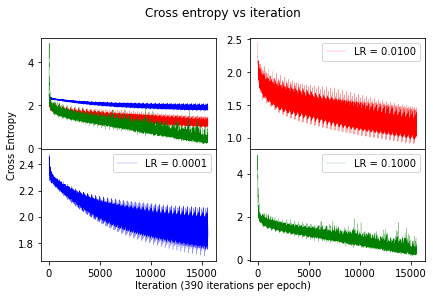

In [14]:
# Plot cross entropy for each batch 

fig, ax = plt.subplots(2, 2, sharex='col',gridspec_kw={'hspace': 0}) #plt.subplots(2, 2)
fig.suptitle("Cross entropy vs iteration", fontsize=12)
x = np.arange(1, len(losses[0,:])+1)
ax[0, 0].plot(losses[0,:], label="%1.4f" % lr0, color='r', linewidth=0.2)
ax[0, 0].plot(losses[1,:], label="%1.4f" % lr1, color='b', linewidth=0.2)
ax[0, 0].plot(losses[2,:], label="%1.4f" % lr2, color='g', linewidth=0.2)

ax[0, 1].plot(losses[0,:], label="LR = %1.4f" % lr0, color='r', linewidth=0.2)
ax[0, 1].legend()
ax[1, 0].plot(losses[1,:], label="LR = %1.4f" % lr1, color='b', linewidth=0.2)
ax[1, 0].legend()
ax[1, 1].plot(losses[2,:], label="LR = %1.4f" % lr2, color='g', linewidth=0.2)
ax[1, 1].legend()
fig.text(0.5, 0, 'Iteration (%d iterations per epoch)' % num_batches, ha='center')
fig.text(0, 0.5, 'Cross Entropy', va='center', rotation='vertical')
ax[0, 1].legend()
plt.tight_layout()
plt.show()

We can see firstly that this line has a lot of noise, this is because each batch is being plotted and due to the batches being different it is not surprising that they produce very different loss values.

 
Initially the loss is high, this is because our model is initialised with random weights and therefore a random prediction is given. 

Infact, let us consider the expected value of the loss in this case:
\begin{align}
\text{Random } W, b &\implies \text{Random Neural network} \\
& \implies \mathbb{E} \left[ \hat{y} \right] =\left[ 0.1, 0.1, \dots, 0.1 \right]^T \\
& \implies \mathcal{L}(\hat{y}, y) = -log(0.1) \approx 2.30
\end{align}

Where we assume here that a random neural network produces a uniform split across $\hat{y}$. We can see that this is generally the initial case.

The model then has decreasing error as we pass more iterations, since the model is 'learning' more apropriate biases and weights.

Due to the noise of this graph it is difficult to see anything more than the general shape of the graph. I therefore plot the cross entropy for each epoch against the training set and the test set:

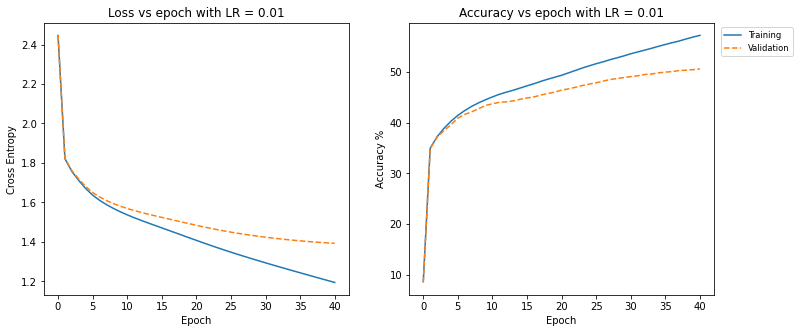

In [15]:
# Plot cross entropy and accuracy for each epoch.
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
x = np.arange(1,epochs+1)
cols = ['r', 'b', 'g'] # Colours
lrs=[lr0, lr1, lr2]
i=0
plt.plot(losses_train[i,:])
plt.plot(losses_val[i,:], linestyle='--')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Loss vs epoch with LR = %1.2f' % lrs[i])

fig.add_subplot(122)  
plt.plot(acc_train[i,:], label='Training')
plt.plot(acc_val[i,:], label='Validation', linestyle='--')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy vs epoch with LR = %1.2f' % lrs[i])
plt.legend(bbox_to_anchor=(1.01, 1), fontsize='small')
plt.show()

Let us now analyse these graphs: 

+ Cross entropy: As expected there is a sharp initial decrease (from $log(0.1) \approx 2.3$), in both the validation and training cross entropies as it is easy for the model to improve on the random intitial weights and zero biases. After this, there is a slower decrease in cross entropy for both the sets. However beyond about epoch 15 the cross entropy of the training set decreases at a faster rate than that of the test set, this is due to the fact the model is beginning to overfit the training data. The validation data seems like it is converging to a cross entropy of about 1.4 while the train data's cross entropy is still decreasing.

+ Accuracy: The accuracy follows a similar pattern to the cross entropies but increases instead of decreases. An almost identical conclusion can be drawn from looking at the accuracies in this case: both set's accuracies initially increase rapidly and similarly, however eventually the validation set's accuracy begins to plateau due to the model fitting the training data more closely. The validation data seems like it is converging to an accuracy of about 50% while the training data's accuracy is still increasing.


### Task 1.1.2

As explained above I already created and trained a model using learing rates 0.0001, and 0.1 respectively in an attempt to be more efficient. Their accuracies and cross entropies are plotted below, while their per-batch loss can be seen in the figure above.  

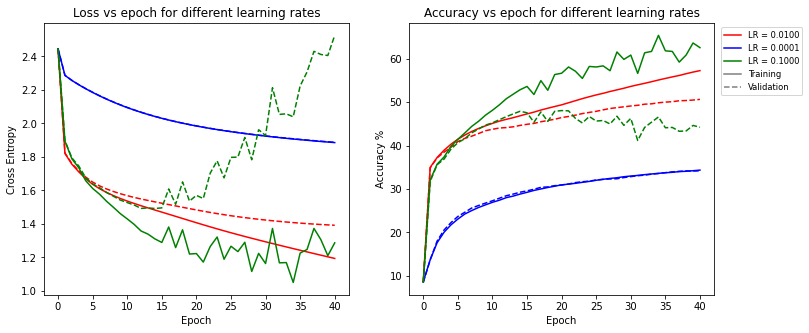

In [16]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
for i in [0, 1, 2]:
    plt.plot(losses_train[i,:], color=cols[i], linestyle='-')
    plt.plot(losses_val[i,:], color=cols[i], linestyle='--')
    plt.ylabel('Cross Entropy')
    plt.xlabel('Epoch')
    plt.title('Loss vs epoch for different learning rates')
    plt.plot([], [], color=cols[i], label= "LR = %1.4f" % lrs[i])
plt.plot([], [], color='grey', linestyle='-')
plt.plot([], [], color='grey', linestyle='--')

fig.add_subplot(122)
for i in [0, 1, 2]:
    plt.plot(acc_train[i,:], color=cols[i], linestyle='-')
    plt.plot(acc_val[i,:], color=cols[i], linestyle='--')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.title('Accuracy vs epoch for different learning rates')
    plt.plot([], [], color=cols[i], label= "LR = %1.4f" % lrs[i])
plt.plot([], [], color='grey', linestyle='-', label='Training')
plt.plot([], [], color='grey', linestyle='--', label='Validation')
plt.legend(bbox_to_anchor=(1.01, 1), fontsize='small')
plt.show()


+ Cross entropy

We can notice that with all learning rates there is an intial steep decrease from a cross entropy of 2.3, as we would expect. 

However with the smallest learning rate (0.0001) this quickly slows to a shallow curve as the updates to the weights and biases are minute, it does not show any signs of overfitting with both training and validation curves being near identical. It converges to a loss of about 1.9.

The learning rate of 0.1 provides the opposite, with it quickly reaching a minimum and then overfitting (after about epoch 10) the training data as the cross entropy of the validation set increases. We can see that it produces a more chaotic line with jumps, this is because the large learning rate causes the algorithm to update the weights and biases and 'overshoot' the minimum desired. The validation loss doesn't converge and simply keeps increasing (after reaching a minimum of about 1.5).

The learning rate of 0.01 provides a good balance between the above learning rates, with it being a large enough to provide meaningful updates to the weights and biases, that is it quickly reduces the cross entropy of both the training and validation sets, and not too large such that it overshoots and produces non-smoothness. Though there is some signs of overfitting from about epoch 15, when the validation set loss plateaus to ~1.4 while the test set loss continues to decrease.






+ Accuracy


A very similar analysis can be performed for the accuracy giving a similar conclusion. 

Again the learning rate of 0.0001 provides no signs of overfitting, likely due to the small updates made because of the small learing rate and it seems to converge to a low accuracy of about 30% after initially increasing fairly rapidly.

In the learning rate = 0.1 case we can see there is a rapid increase in accuracy to about 50% before it plateaus at about epoch 10 (and slowly decreases), while the training accuracy increases. We can see overfitting does seem to occur quickly and the plot is not smooth, likely due to the large learning rate causing the gradient descent method to overshoot the maximum. It is also interesting to note the overfitting is less prominant than in the cross entropy plot, since the validation accuracy only very slowly decreases. This is likely because it is predicting the right result in the majority of cases (since the accuracy remains fairly high, despite decreasing)  just with less certainty (hence the large increase in cross entropy).

Again the 0.01 learning rate seems to provide a compromise. But does exhibit some slight overfitting after about epoch 15, though the accuracy on both sets still increases, with the accuracy on the validation set to plateauing at about 50%.

The overall conclusion from both plots is that the learning rate of 0.01 provides a good balance between the slow convergence of the 0.0001 learning rate and the rapid convergence yet easy overfitting of the 0.1 learning rate.


### Task 1.1.3

Below I continue the training of the neural network for a further 40 epoch (80 epochs total).

In [17]:
# Continue the the lr = 0.01 model for a further 40 epochs (a total of 80).
# Initilise
losses0 = np.empty(epochs*num_batches)
losses_train0 = np.empty(epochs)
losses_val0 = np.empty(epochs)
acc_train0 = np.empty(epochs)
acc_val0 = np.empty(epochs) 


for epoch in range(epochs):
    print('Epoch %d/%d' % (epoch+41, 80))
    
    indx0 = num_batches*epoch
    for r in rng_num_batches:

        y_pred, a0, h0 = mlp(x_batches[r], weights0, biases0)
        losses0[indx0+r] = sum(loss(y_pred, y_batches[r]))
        d_k_plus1_0 = y_pred - y_batches[r] # dL_da (delta6)

        
        for k in ks: # 5,4,3,2,1
        
            d_k0 = back(d_k_plus1_0, weights0[k], a0[k]) # Calculate next error without changing weights/biases
            
            grad_W = h0[k].T@d_k_plus1_0 # This is the SUM not the mean, the mean is found later.
            grad_b = np.sum(d_k_plus1_0, axis=0)
            weights0[k] = weights0[k] - lr_batch0*grad_W # Change weights NB also dividing by batch size (mean)
            biases0[k] =  biases0[k] - lr_batch0*grad_b # Change biases NB also dividing by batch size (mean)

            d_k_plus1_0 = d_k0
            
            
            
        # Input to first hidden layer weights & biases
        k=0
        ## i)  lr = 0.01
        grad_W = h0[k].T@d_k_plus1_0
        grad_b = np.sum(d_k_plus1_0, axis=0)
        weights0[0] = weights0[0] - lr_batch0*grad_W
        biases0[0] =  biases0[0] - lr_batch0*grad_b

    # Calculate Accuracies and losses
    y_pred = mlp(flat_x_train, weights0, biases0, verbose=False)
    losses_train0[epoch] = sum(loss(y_pred, y_train))
    acc_train0[epoch] = sum(y_train[i_y_train, np.argmax(y_pred, axis=1)])
    y_pred = mlp(flat_x_val, weights0, biases0, verbose=False)
    losses_val0[epoch] = sum(loss(y_pred, y_val))
    acc_val0[epoch] = sum(y_val[i_y_val, np.argmax(y_pred, axis=1)])

# Convert sums to means (as before)
losses0 /= batch_size 
losses_train0 /= num_train
losses_val0 /= num_val
acc_train0 /= (num_train*0.01)
acc_val0 /= (num_val*0.01)



# Concatenate losses and errors together with values from first 40 epochs 
losses0 = np.concatenate((losses[0, :], losses0))
losses_train0 = np.concatenate((losses_train[0, :], losses_train0))
losses_val0 = np.concatenate((losses_val[0, :], losses_val0))
acc_train0 = np.concatenate((acc_train[0, :], acc_train0))
acc_val0 = np.concatenate((acc_val[0, :], acc_val0))
  

Epoch 41/80
Epoch 42/80
Epoch 43/80
Epoch 44/80
Epoch 45/80
Epoch 46/80
Epoch 47/80
Epoch 48/80
Epoch 49/80
Epoch 50/80
Epoch 51/80
Epoch 52/80
Epoch 53/80
Epoch 54/80
Epoch 55/80
Epoch 56/80
Epoch 57/80
Epoch 58/80
Epoch 59/80
Epoch 60/80
Epoch 61/80
Epoch 62/80
Epoch 63/80
Epoch 64/80
Epoch 65/80
Epoch 66/80
Epoch 67/80
Epoch 68/80
Epoch 69/80
Epoch 70/80
Epoch 71/80
Epoch 72/80
Epoch 73/80
Epoch 74/80
Epoch 75/80
Epoch 76/80
Epoch 77/80
Epoch 78/80
Epoch 79/80
Epoch 80/80


I then plot the per batch cross entropy below:

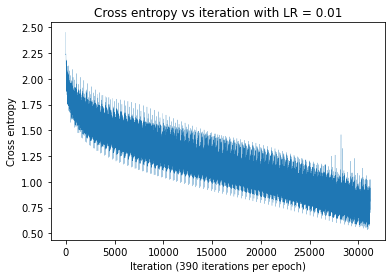

In [18]:
# Plot cross entropy for each batch 
x = np.arange(1,len(losses0) + 1)
plt.plot(losses0, label="%1.2f" % lr0, linewidth=0.2)
plt.ylabel("Cross entropy")
plt.xlabel('Iteration (%d iterations per epoch)' % num_batches)
plt.title("Cross entropy vs iteration with LR = %1.2f" % lr0)
plt.show()

It can be seen that, as expected the graph is noisy and shows decreasing cross entropy.

To provide a better visual, below I plot the per epoch training and validation accuracies: 

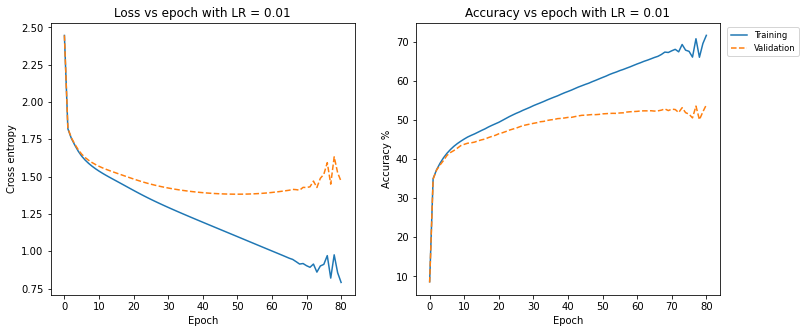

In [19]:
# Plot cross entropy and accuracy for each epoch.
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
plt.plot(losses_train0)
plt.plot(losses_val0, linestyle='--')
plt.ylabel("Cross entropy")
plt.xlabel('Epoch')
plt.title('Loss vs epoch with LR = %1.2f' % lr0)

# Plot accuracy for each epoch. 
fig.add_subplot(122)
plt.plot(acc_train0, label='Training')
plt.plot(acc_val0, label='Validation', linestyle='--')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy vs epoch with LR = %1.2f' % lr0)
plt.legend(bbox_to_anchor=(1.01, 1), fontsize='small')
plt.show()

+ Cross entropy

We can see that by epoch 80 our neural network has overfit the training data, it appears that the overfitting has began to occur at about epoch 15 where the training and validation curves separate. The validation cross entropy is minimised at about epoch 40 of a value of about 1.4, beyond this it gradually increases to about 1.5 by epoch 80. We can see at about epoch 75 there is some non-smoothness occuring. This is likely caused as the weights and biases are now in the neigbourhood of the optimal weights sought by gradient descent and so the learning rate becomes too course meaning the optimums are overshot, producing some jumps.

+ Accuracy

Signs of overfitting can be seen initially at about epoch 15 where the training and validation curves diverge, then the validation curve begins to plateau at an accuracy of about 50% while the training curve increases. The non-smoothness is also seen at about epoch 75, likely due to the same reasons mentioned above. Where at epoch 80 the model converges to a validation accuracy of about 50%.

Now considering the hyperparameters that is the epochs and learning rate:

+ Learning rate: 
  
  The learning rate of 0.0001 does not provide a good accuracy and cross entropy after 40 epochs. Mathematically, this is because the learning rate is too small, and so the updates to the weights and biases are small and hence the improvements on the accuracy and cross entropy per epoch are small. Because of this small learning rate, and only 40 epochs no overfitting is seen.  

  The learning rate of 0.1 also performs poorly. Mathematically this is because the updates to the weights and biases are too large and hence the optimal weights and biases are not found but instead 'overshot' due to the large learning rate. We have that overfittng quickly occurs because of this large learning rate

  The learning rate of 0.01 provides a compromise between this, since the learning rate is small enough not to overfit within the first 40 epochs and also provide fairly significant improvements on the loss and accuracy. 
  
  Ideally this parameter would be tuned to decrease as the model progresses through training. 

+ Number of epochs:

  This simply equates to training the model for longer. As we have seen, in the learning rate = 0.01 case we can see no overfitting in the first 40 epochs, though within 80 epochs we can see the signs of overfitting appearing. Ideally this hyperparmeter would be controlled by using early stopping. Hence overall the model attains a better result after only 40 epochs since at this stage overfitting has yet to occur.

## Task 1.2 Convolutional neural network (CNN)

Note: To take advantage of the optimallity of using a GPU with tensorflow for this I now switch to running python with a GPU hence the required modules and data are (re)imported.

In [1]:
import time
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping
from scipy.sparse import linalg
from google.colab import drive
import networkx as nx
import pandas as pd
import seaborn as sn
import networkx.algorithms.community as nxcom

In [2]:
# Load Data Function (as given to us).
def load_data():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 255
    x_val = x_val.astype('float32') / 255
    
    # Convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
    
    return ((x_train, y_train), (x_val, y_val))

# Load the data.   
(x_train, y_train), (x_val, y_val) = load_data()

# Set the type of the data, shuffle it and sort it into batches
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(1024)
train_data = train_data.batch(128)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(128)

170500096/170498071 [==============================] - 11s 0us/step


### Task 1.2.1


As in the coding task notes I use tensorflow to create the model required. The architecture of the model is displayed in the summary below. Where it has been created using the `get_model()` function defined below, with an optimiser of stochastic gradient descent with a learning rate of 0.1.

In [3]:
# 1st model - Task 1.2.1
def get_model():
    model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
            MaxPool2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPool2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax')
            ])
    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model_121 = get_model()
model_121.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

Hence we have the following architecture:
+ Input layer (Shape: $32 \times 32 \times 3$) 
+ Hidden Layers:
  + Convolution layer (32 Neurons), Relu activation 
  + Max pooling layer ($2 \times 2$)
  + Convolution layer (64 Neurons), Relu activation 
  + Max pooling layer ($2 \times 2$)
  + Convolution layer (64 Neurons), Relu activation 
  + Flatten data
  + Dense layer (64 Neurons), Relu activation 
+ Output layer (10 outputs), softmax activation


I now train the model, to do this I define a function `train_model()`, this is done below, and the function is called to train the model.

In [4]:
def train_model(model):
    history = model.fit(train_data, epochs=40, verbose=2, validation_data=val_data)
    return history

history_121 = train_model(model_121) # Train model

Epoch 1/40
391/391 - 32s - loss: 2.0670 - accuracy: 0.2510 - val_loss: 1.9214 - val_accuracy: 0.3007
Epoch 2/40
391/391 - 2s - loss: 1.6607 - accuracy: 0.4051 - val_loss: 1.5124 - val_accuracy: 0.4665
Epoch 3/40
391/391 - 2s - loss: 1.4197 - accuracy: 0.4901 - val_loss: 1.3243 - val_accuracy: 0.5274
Epoch 4/40
391/391 - 2s - loss: 1.2869 - accuracy: 0.5435 - val_loss: 1.2858 - val_accuracy: 0.5453
Epoch 5/40
391/391 - 2s - loss: 1.1814 - accuracy: 0.5814 - val_loss: 1.2096 - val_accuracy: 0.5722
Epoch 6/40
391/391 - 2s - loss: 1.0890 - accuracy: 0.6155 - val_loss: 1.1687 - val_accuracy: 0.5762
Epoch 7/40
391/391 - 2s - loss: 1.0204 - accuracy: 0.6425 - val_loss: 1.0725 - val_accuracy: 0.6281
Epoch 8/40
391/391 - 2s - loss: 0.9487 - accuracy: 0.6670 - val_loss: 1.0693 - val_accuracy: 0.6289
Epoch 9/40
391/391 - 2s - loss: 0.8942 - accuracy: 0.6864 - val_loss: 1.0594 - val_accuracy: 0.6372
Epoch 10/40
391/391 - 2s - loss: 0.8418 - accuracy: 0.7048 - val_loss: 1.0645 - val_accuracy: 0.638

The respective accuracies and cross entropies are plotted below:

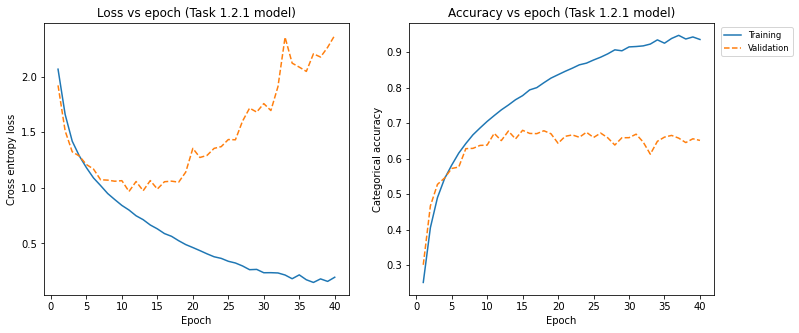

In [5]:
# Plot accuracies and Loss of model from 1.2.1

fig = plt.figure(figsize=(12, 5))
x = np.arange(1, 41)

fig.add_subplot(121)
plt.plot(x, history_121.history['loss'])
plt.plot(x, history_121.history['val_loss'], linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch (Task 1.2.1 model)")


fig.add_subplot(122)
plt.plot(x, history_121.history['accuracy'], label='Training')
plt.plot(x, history_121.history['val_accuracy'], label='Validation', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch (Task 1.2.1 model)")
plt.legend(bbox_to_anchor=(1.01, 1), fontsize='small')

plt.show()

+ Cross entropy: the cross entropy for both the training and validation sets show a sharp decrease for about the first 5 epochs. After this the validation loss begins to increase (due to the model overfitting the training data), while the training loss decreases. The validation loss increases to about 2.4, this is far above the loss that the random initialisation provides. Further the non-smoothness seen is likely due to the large learning rate causing the gradient descent to overshoot the minimum it seeks. 

+ Accuracy: the accuracy of both data sets increases rapidly for the first 5 epochs, the training set's accuracy continues to increase, though slowing down slightly for the following epochs. The validation set accuracy, however, increases to an accuracy of about 0.65 at epoch 10, at which it plateaus and remains at approximately this accuracy, decreasing marginally.

### Task 1.2.2

(Kernel) $L_2$ regularisation is implimented to help reduce overfititng. It does this be penalising large weights used in the model. This is done by amending the loss function to include this penalty, as described in the lecture notes:
$$
\mathcal{L}(W, \alpha) = \mathcal{L}_0(W) + \frac{\alpha}{2}\sum_i w_i^2
$$

Where $\alpha$ is the regularisation parameter (in our case $\alpha = 5 \times 10^{-3}$).

This is implimented in the model below, which is then trained for 40 epochs.

In [6]:
def get_model():
    model = Sequential([
            Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(5e-3), input_shape=(32, 32, 3)),
            MaxPool2D((2, 2)),
            Conv2D(64, (3, 3), kernel_regularizer=l2(5e-3), activation='relu'),
            MaxPool2D((2, 2)),
            Conv2D(64, (3, 3), kernel_regularizer=l2(5e-3), activation='relu'),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax')
            ])
    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model_122 = get_model()
model_122.summary()

history_122 = train_model(model_122) # Train model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

The correponding validation and training set accuracies and losses are plotted for each epoch below:

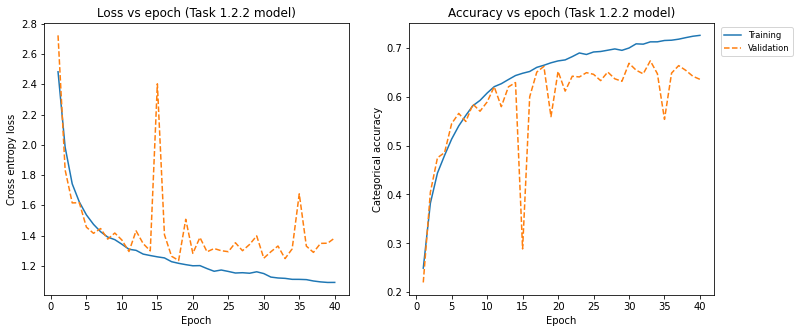

In [7]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(x, history_122.history['loss'])
plt.plot(x, history_122.history['val_loss'], linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch (Task 1.2.2 model)")

fig.add_subplot(122)
plt.plot(x, history_122.history['accuracy'], label='Training')
plt.plot(x, history_122.history['val_accuracy'], label='Validation', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch (Task 1.2.2 model)")
plt.legend(bbox_to_anchor=(1.01, 1), fontsize='small')
plt.show()


+ Cross entropy: the cross entropy of both sets initially decreases rapidly, whereby at about epoch 15 the validation cross entropy seems to have converged to a value of about 1.3. Beyond epoch 15 the cross entropy of the validation set fluctuates quite a bit but remains approximately at this level, due to the $L_2$ regularisation, at the same time the training cross entropy decreases slowly.

+ Accuracy: initially both sets' accuracies increase until about epoch 15 where the validation accuracy converges (though still fluctuates) to about 0.65, again the overfitting is nominal due to the use of the $L_2$ regulariser, though the training accuracy converges to about 0.7, far higher than the validation accuracy. 

The intoduction of the $L_2$ regulariserr also brings in a lot of fluctuations in the losses and accuracies.

Below I compare the use of the $L_2$ regulariser to the model in Task 1.2.1, where no regulariser is used.

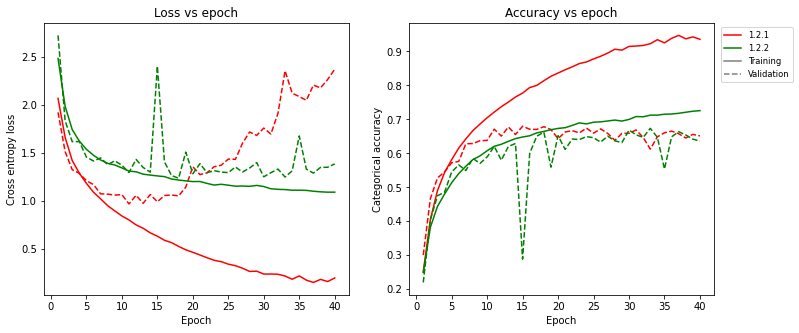

In [8]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(x, history_121.history['loss'], color='r')
plt.plot(x, history_121.history['val_loss'], color='r', linestyle='--')
plt.plot(x, history_122.history['loss'], color='g')
plt.plot(x, history_122.history['val_loss'], color='g', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch")


fig.add_subplot(122)
plt.plot(x, history_121.history['accuracy'], color='r', label="1.2.1")
plt.plot(x, history_121.history['val_accuracy'], color='r', linestyle='--')
plt.plot(x, history_122.history['accuracy'], color='g', label="1.2.2")
plt.plot(x, history_122.history['val_accuracy'], color='g', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")
plt.plot([], [], color='grey', linestyle='-', label='Training')
plt.plot([], [], color='grey', linestyle='--', label='Validation')
plt.legend(bbox_to_anchor=(1.01, 1), fontsize='small')
plt.show()


We can see that there are some clear differences between the models:

+ Cross entropy: we can see the $L_2$ regulariser prevents the model from overfitting, and after 40 epochs the regularised model fits the data better than the model without it since it hasn't overfitted. Although the non-regularised model does achieve a lower minimum cross entropy (achieved at about 10 epochs)

+ Accuracy: we can see that the validation accuracies follow an very similar pattern between the models, though the training accuracy of model 1.2.2 is far less than that of model 1.2.1 due to the $L_2$ regulariser.

### Task 1.2.3

#### Task 1.2.3a Dropout model

Below I implement and train the dropout model, as described in the lecture notes. That is nodes are 'dropped' from the model with a set probability (0.5 in our case) in training. This prevents the model from becoming too reliant on certian nodes and builds a more robust model. The final model then contains all nodes, with weights scaled by the afore mentioned probability.

I decided to implement a dropout layer directly before the output layer. I did this after researching (https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) and finding that a dropout with rate 0.5 is found to be most effective when applied here.

In [9]:
def get_model():
    rate=0.5
    model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
            MaxPool2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPool2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(rate),
            Dense(10, activation='softmax')
            ])
    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model_123a = get_model()
model_123a.summary()

history_123a = train_model(model_123a)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

This model's accuracies and cross entropy losses are plotted below:

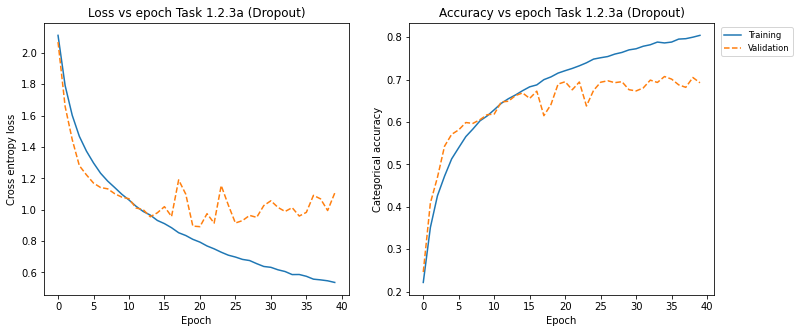

In [10]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_123a.history['loss'],)
plt.plot(history_123a.history['val_loss'], linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch Task 1.2.3a (Dropout)")

fig.add_subplot(122)
plt.plot(history_123a.history['accuracy'], label='Training')
plt.plot(history_123a.history['val_accuracy'], label='Validation', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch Task 1.2.3a (Dropout)")
plt.legend(bbox_to_anchor=(1.01, 1), fontsize='small')
plt.show()

+ Cross entropy: we can see that the cross entropy decreases until around epoch 15 where the validation cross entropy begins to fluctuate more and very slightly increases to a cross entropy of about 1, this is the begininng of overfitting, while the training cross entropy continues to decrease.

+ Accuracy: we can similarly see there is an increase in accuracy until about epoch 15 when the validation accuracy plataus at about 0.7, while the training accuracy continues to increase.


#### Task 1.2.3b Early stopping model

There are a variiety of other regulariser that are aimed at improving neural networks, including: 
+ $L_1$ regularisation, which acts almost identically to $L_2$ regularisation except uses a $L_1$ norm instead of $L_2$ norm. This aims to introduce weights with 0 values.
+ Bias regularisation, which penalises bias terms similar to as we have done before with the weights. 

However, below I impliment early stopping on an identical model to as in Task 1.2.1 with a patience of 10. Early stopping aims to stop the training of the model before the loss on the validation set increases. However due to fluctuations in the loss we use an additional parameter - patience. Patience defines the number of epochs allowed where the loss doesn't improve on the best score so far. If the patience threshold is reached then training is terminated. (I have set pateince to 10 below).  

In [11]:
def get_model():
    model = tf.keras.models.clone_model(model_121)
    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
model_123b = get_model()
model_123b.summary()

def train_model(model):
    early_stopping = EarlyStopping(patience=10, monitor='val_accuracy')
    history = model.fit(train_data, epochs=80, verbose=2, validation_data=val_data,
                        callbacks=[early_stopping])
    return history

history_123b = train_model(model_123b)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

The results of this model are plotted below:

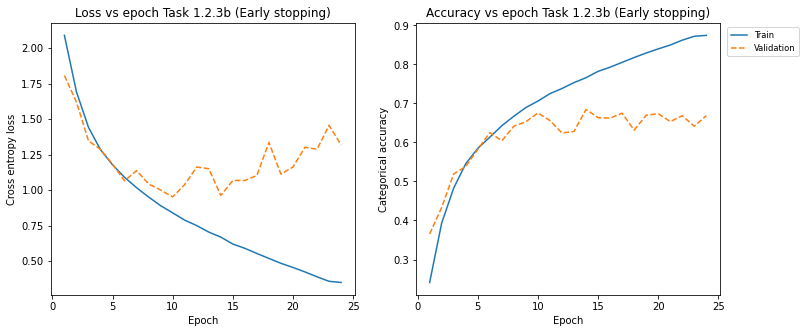

In [12]:
fig = plt.figure(figsize=(12, 5))

x = np.arange(1, len(history_123b.history['loss'])+1)
fig.add_subplot(121)
plt.plot(x, history_123b.history['loss'], label='Train')
plt.plot(x, history_123b.history['val_loss'], label='Validation', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch Task 1.2.3b (Early stopping)")

fig.add_subplot(122)
plt.plot(x, history_123b.history['accuracy'], label='Train')
plt.plot(x, history_123b.history['val_accuracy'], label='Validation', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch Task 1.2.3b (Early stopping)")
plt.legend(bbox_to_anchor=(1.01, 1), fontsize='small')

plt.show()

The results of the early stopping regularisation are not surprising, since it uses the same architecture as the model from task 1.2.1. We can see that the the early stopping has indeed stopped training early, and shortly after the loss begins to increase. The model has been stopped at about epoch 25 and a validation loss of 1.5. 

The accuracy of the model has converged to about 0.65 by the end of training, after an initial increase.

It should be noted that overfitting has still begun to occur and can be seen in both plots: the loss (accuracy) of the training data decreases (increases) while the validation data plateaus and does the opposite.

To compare this to some of the previous models I plot their losses and accuracies on the same graph as below:

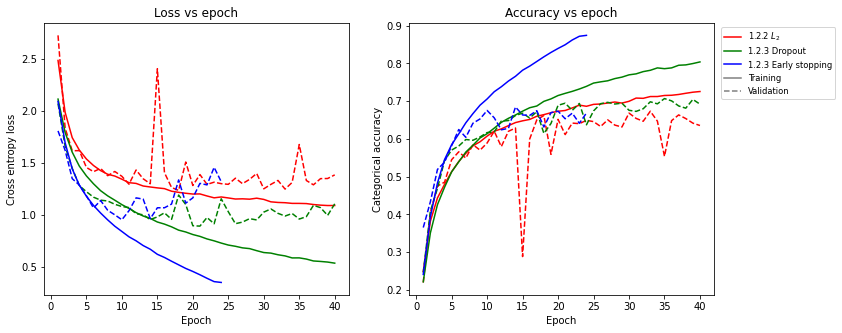

In [13]:
fig = plt.figure(figsize=(12, 5))
x = np.arange(1, len(history_122.history['loss'])+1)
fig.add_subplot(121)
x1 = np.arange(1, len(history_123b.history['loss'])+1)
plt.plot(x, history_122.history['loss'], color='r')
plt.plot(x, history_122.history['val_loss'], color='r', linestyle='--')
plt.plot(x, history_123a.history['loss'], color='g')
plt.plot(x, history_123a.history['val_loss'], color='g', linestyle='--')
plt.plot(x1, history_123b.history['loss'], color='b')
plt.plot(x1, history_123b.history['val_loss'], color='b', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch")


fig.add_subplot(122)
plt.plot(x, history_122.history['accuracy'], color='r', label="1.2.2 $L_2$")
plt.plot(x, history_122.history['val_accuracy'], color='r', linestyle='--')
plt.plot(x, history_123a.history['accuracy'], color='g', label="1.2.3 Dropout")
plt.plot(x, history_123a.history['val_accuracy'], color='g', linestyle='--')
plt.plot(x1, history_123b.history['accuracy'], color='b', label="1.2.3 Early stopping")
plt.plot(x1, history_123b.history['val_accuracy'], color='b', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")
plt.plot([], [], color='grey', linestyle='-', label='Training')
plt.plot([], [], color='grey', linestyle='--', label='Validation')
plt.legend(bbox_to_anchor=(1.01, 1), fontsize='small')
plt.show()


+ Cross entropy: the cross entropy of the dropout regulated model is far lower than that of both the early stopping and the $L_2$ model. The early stopping model performs slightly better than the $L_2$ regularised system, converging to a slightly smaller validation cross entropy.

+ Accuracy: the accuracies of all three models are very similar, however after training the accuracies are in the following order: model from Task 1.2.2 < model Task 1.2.3 (early stopping) < model from Task 1.2.3 (dropout).

### Task 1.2.4

+ Accuacy: the accuracy of the CNN in task 1.2.3 (dropout) at about 70% is far higher than that of the model produced in task 1.1.1 which in turn produces a validation accuracy of 50%


+ Computational time: as printed above the computational time for the model in task 1.1.1 is about 14s per epoch, compared to 2s per epoch for the model in task 1.2.3a, this is far quicker, likely due to the efficient implimentation of the model in tensorflow, as well as the fact that tensorflow is optimised for use on GPUs. 

+ Parameters: as we can see below (where the number of parameters has been calculated)  the model in task 1.2.3 has significantly fewer parameters (over 10x fewer)  than the model in task 1.1.1. This is due to the fact that the model in task 1.2.3 used pooling layers that reduce the dimensionality of the data before it is passed to the next layer, while the model in 1.1.1 uses fully connected layers with far more nodes. This can also explain the far quicker training of the model in task 1.2.3 against the model in task 1.1.1

It is not surprising that the CNN model performs significantly better than the model in 1.1.1 on this data set in images, since aside from the optimised implimentation of the CNN model. When flattening out data from an image into a vector we lose all (spatial) dependencies of the data and hence we are essentially losing valuable information, this is not lost in the CNN model, since the location (x-position, y-position and colour channel) are retained. It is also interesting to note that despite the model in 1.1.1 having far more paramters it performs worse, and hence more paramters does not necessarily lead to a better model.



In [14]:
bias_len = 400*5 + 10 # Total bias parameters
weights_size = (3072*400) + (400*400)*4 + (400*10) # Total weight parameters
total = weights_size + bias_len
print('Total paramters in Task 1.1.1', total)
print('Total paramters in Task 1.2.3', 122570)

Total paramters in Task 1.1.1 1874810
Total paramters in Task 1.2.3 122570


Below I have constructed a tabel to concisely compare what has been discussed above:


|                        	| Model 1.1.1   	| Model 1.2.1 	| Model 1.2.2 	| Model 1.2.3a  	| Model 1.2.3b  	|
|------------------------	|---------	|-------	|-------	|---------	|---------	|
| Final Accuracy (%)     	| 50      	| 65    	| 65    	| 70      	| 65      	|
| Final loss             	| 1.4     	| 2.4   	| 1.3   	| 1       	| 1.5     	|
| Overrfitting occurred? 	| Minimal 	| Large 	| No    	| Minimal 	| Minimal 	|

# Task 2 Unsupervised learning


## Task 2.1 Clustering of the feature matrix

Firstly to import the data:

In [15]:
# Import data 
drive.mount('/content/drive')
X = np.genfromtxt('/content/drive/MyDrive/CW_FILES/Feature matrix karate club.csv', delimiter=',')
X = X[1:,1:] # Remove Headers and Indexes

Mounted at /content/drive


### Task 2.1.1

Since the k-means algorithm uses distances, to ensure all covariates have equivalent distances I normalise my data:

In [16]:
def normalise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

X = normalise(X)

I then define a `kmeans()` as in the coding tasks. 

To ensure that the k-means algorithm doesn't produce empty clusters, I made two ammendments from the coding task:

+ Ensured that the random initialisation doesn't produce any empty clusters, by forcing at least one element in each cluster.

+ In each iteration, after the new labels are calculated by assigning individuals to their nearest centroid, if there are any empty clusters, the individual in the largest cluster (with respect to number of elements) that is furthest from the centroid it has been assigned is moved to the empty cluster. This is repeated until all empty clusters have been filled. This method although not flawless provides an efficient (without having to recalculate the distance matrix) method of filling empty groups.

this function is defined below:



In [17]:
def kmeans(X, k, max_iter):
    
    n_samples, n_features = X.shape
    assert(k <= n_samples)
    ks = np.arange(k)
    rng_k = range(k)
    
    # labels: assign every sample to a cluster at random
    labels = np.random.randint(k, size=n_samples)
    # Ensure no empty clusters
    labels[:k] = ks
    np.random.shuffle(labels) 
    
    # computing the centroids of each of the k clusters
    centroids = np.empty((k, n_features))
    for r in rng_k:
        centroids[r] = np.mean(X[labels==r], axis=0)
        
    
    # k-means algorithm
    distances = np.empty((k, n_samples))
    for i in range(max_iter):
        # distances: between data points and centroids
        for j in rng_k:
            a = X - centroids[j]
            distances[j, :] = np.einsum('ij,ij->i', a, a) # Is distances squared
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)
            
            
        if (labels==new_labels).all():
            # labels unchanged
            break
        else:
            # Ensures that the new labels do not have an empty cluster, if they 
            # do it moves the individual, from the largest (sized) cluster, 
            # that is furthest from its assigned centroid to a new cluster.
            for diff in np.setdiff1d(ks, new_labels):
                big = np.argmax(np.bincount(new_labels))
                max_d = max(distances[big, :][new_labels==big])
                new_labels[(distances[big, :]==max_d)] = diff
            
            # labels changed
            labels = new_labels
            for c in rng_k:
                # update centroids by taking the mean over associated data points
                centroids[c] = np.mean(X[labels==c], axis=0)

    return labels, centroids

To compare the distances between the clusters I define the function `within_distance()`, which calculates the within distance as defined in lectures:
+ Within distance:
$$
W(\mathcal{C}) := \frac{1}{2}\sum_{l=1}^{k} \frac{1}{|c_l|} \sum_{i,j \in c_l} \lVert x^{(i)}- x^{(j)} \rVert^2
$$

In [18]:
# Calculate the within distance as per lecture notes 
def within_distance(X, k, labels):
    W = 0
    for c in range(k):
        cond = (labels == c)
        if cond.any():
            norm=0
            X_sub = X[cond]
            len_X_sub = len(X_sub)
            for i in range(len_X_sub):
                a = X_sub - X_sub[i]
                norm += sum(np.einsum('ij,ij->i',a,a))
            W += norm / len_X_sub
    W *= 0.5
    return W

I next define a function that calculates the within distance, using `within_distance()`, and the labels for the clustering found by the k-means algorithm it does this for a given number of random initialisations.

In [19]:
# Wrapper function to calculate the within distance and the labels for a set 
# number of iterations of the k means algorithm
def iter_kmeans_W(X, k, max_iter, num_iterations=100):
    Ws = np.empty(num_iterations)
    labels_k = np.empty((len(X), num_iterations))
    for i in range(num_iterations):
        labels, centroids = kmeans(X, k, max_iter)
        Ws[i] = within_distance(X, k, labels)
        labels_k[:, i] = labels
    return Ws, labels_k

I then use this function to calculate the within distances for 100 random initialisations for all $k=2,3, \dots 10$. 


In [20]:
# Initialise 
np.random.seed(112511190) 
ks = np.arange(2,11)
num_iterations=100
N = len(X)
num_ks = len(ks)
W = np.empty((num_iterations, num_ks))
labels_k = []


# Calculate Within distances for each k for 100 iterations
for i in range(num_ks):
    k = ks[i]
    Ws, labels = iter_kmeans_W(X, k, 20, num_iterations)
    labels_k += [labels]
    W[:, i] = Ws


I now plot the means of the the within distance against their corresponding $k$.

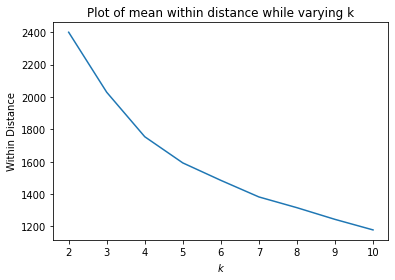

In [21]:
# Plot of mean within distance for each k    
mu_W = np.mean(W, axis=0)  
plt.plot(ks, mu_W) 
plt.xlabel('$k$')
plt.ylabel('Within Distance')
plt.title('Plot of mean within distance while varying k')
plt.show()

It is not surprising that increasing the number of clusters ($k$) reduces the within distance. Ideally a clustering would minimise $W(\mathcal{C})$, however as we increase $k$ we will clearly be decreasing $W(\mathcal{C})$. Therefore instead we seek the 'elbow', that is where increasing $k$ does not provide any significant decrease in $W(\mathcal{C})$. We can see the most prominent elbow at $k=4$. And hence by considering the within distances as above I conclude that $k^*_{\mathcal{W}(C)} = 4$.

Below, to find the optimal clustering, I find the clusterings (from the previous 100 initialisations) that minimise the within distance for $k=4$: 

In [22]:
kstar=4
optimal_labels_W = labels_k[kstar-2][:, np.argmin(W[:, kstar-2])]

headers=["Cluster", "Nodes"]
table = []
for i in range(kstar):
    table += [[i, tuple(np.where(optimal_labels_W==i)[0])]]
print(tabulate(table, headers)) 

  Cluster  Nodes
---------  -------------------------------------------------
        0  (10, 11, 17, 18, 22)
        1  (0, 2, 9, 13, 15, 19, 23, 24, 25, 27, 28, 30, 32)
        2  (5, 7, 14, 16, 20)
        3  (1, 3, 4, 6, 8, 12, 21, 26, 29, 31, 33)


### Task 2.1.2
To define the Calinski-Harabasz Index, let us first recall from lecture notes:
+ Total Sum of Squares (Total dissimilarity):
$$
TSS(\mathcal{C}) := \frac{1}{2N}\sum_{i=1}^{N} \sum_{j=1}^N \lVert x^{(i)}- x^{(j)} \rVert^2
$$
+ Between distance:
$$
B(\mathcal{C}) :=TSS(C)-W(\mathcal{C})
$$

This allows us to easily define the Calinski-Harabasz Index (https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index).

$$
CH(C) := \frac{B(\mathcal{C})}{W(\mathcal{C})}\cdot\frac{N-k}{k-1} = \left(\frac{TSS(C)}{W(\mathcal{C})} -1 \right)\cdot\frac{N-k}{k-1}
$$


We can see that clusters with a large between distance and a small within distance would give a larger CH score, and this clearly represents a good clustering. Hence when examining CH score we seek the largest value.

Below I have calculated the CH score for each of the 100 iterations for all $k=2,3, \dots, 10$ and plotted it against the respective $k$.

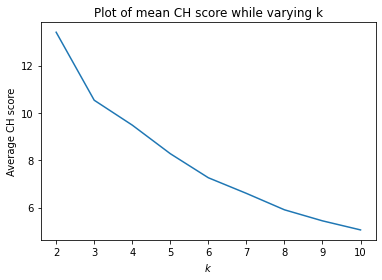

In [23]:
# Calculate the Total dissimilarity as per lecture notes
def total_dis(X):
    norm=0
    len_X = len(X)
    for i in range(len_X):
        a = X - X[i]
        norm += sum(np.einsum('ij,ij->i',a,a))
    W = norm / len_X
    W *= 0.5
    return W

TSS = total_dis(X)
CH = TSS/W - 1
CH *= (N-ks) / (ks-1)

# Plot of mean CH score for each k    
mu_CH = np.mean(CH, axis=0) 
plt.plot(ks, mu_CH)
plt.xlabel('$k$')
plt.ylabel('Average CH score')
plt.title('Plot of mean CH score while varying k')
plt.show()

As we can see the average CH score is decreasing, indicating that the optimal $k$ when considering the CH score is $k^*_{CH(C)} = 2$ (the largest CH score). 

The optimal clustering when considering the CH score can be found by maximising the CH score. I do this across the previous 100 initialisations of the kmeans algorithm for $k=2$ and show this clustering below is shown below.



In [24]:
kstar=2
optimal_labels_CH = labels_k[kstar-2][:, np.argmax(CH[:, kstar-2])]

headers=["Community", "Nodes"]
table = []
for i in range(kstar):
    table += [[i, tuple(np.where(optimal_labels_CH==i)[0])]]
print(tabulate(table, headers)) 

  Community  Nodes
-----------  ----------------------------------------------------------------------
          0  (1, 4, 6, 8, 10, 11, 12, 17, 18, 21, 22, 26, 29, 31, 33)
          1  (0, 2, 3, 5, 7, 9, 13, 14, 15, 16, 19, 20, 23, 24, 25, 27, 28, 30, 32)


### Task 2.1.3

To evaluate the robustness of the k means algorithm we can consider two different aspects: 
1. The variability in the distance measures between the clusterings.
2. The variability in the clusterings produced.

Let us first consider the varibility in distance measures:

#### Varibility in distance measures



##### Within distance

I begin by plotting the variance of the within distance as calculated above, as a function of $k$, next to this I perform a box and whisker plot of these distance measures as a function of $k$.

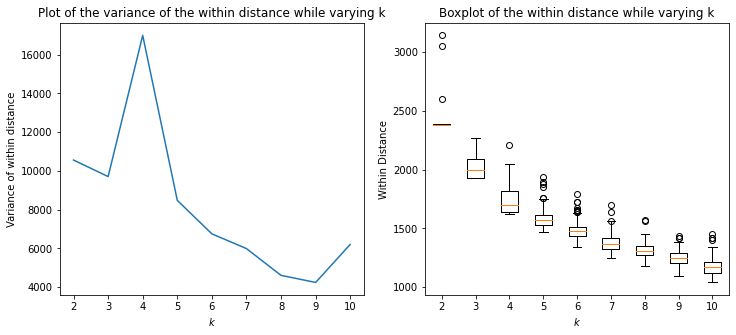

In [25]:
# Plot of variance of within distance for each k
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
var_W = np.var(W, axis=0)
plt.plot(ks, var_W) 
plt.xlabel('$k$')
plt.ylabel('Variance of within distance')
plt.title('Plot of the variance of the within distance while varying k')

fig.add_subplot(122)  
plt.boxplot(W) 
plt.xticks(np.arange(num_ks)+1, ks)
plt.xlabel('$k$')
plt.ylabel('Within Distance')
plt.title('Boxplot of the within distance while varying k')
plt.show()     


##### Calinski Harabasz score

I also produce similar plots for the CH score.

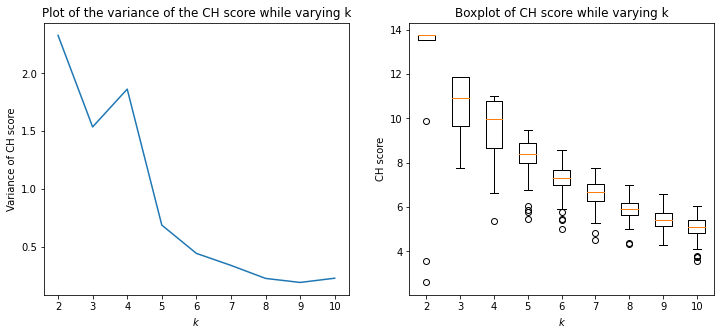

In [26]:
# Boxplot of within distance and CH score for each k    
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
var_CH = np.var(CH, axis=0)   
plt.plot(ks, var_CH)
plt.xlabel('$k$')
plt.ylabel('Variance of CH score')
plt.title('Plot of the variance of the CH score while varying k')


fig.add_subplot(122)  
plt.boxplot(CH)
plt.xticks(np.arange(num_ks)+1, ks) 
plt.xlabel('$k$')
plt.ylabel('CH score')
plt.title('Boxplot of CH score while varying k')
plt.show()

Now I will analyse the variance, as a function of $k$, considering the within distance and the CH score. 

It is useful to consider the box and whisker plot as well as the variance, since the box and whisker plot allows us to see any outliers. 

+ $k=2$. For both the CH score and $\mathcal{W}(C)$ the variance is large, however looking at the box and whisker plots we can see that there are outliers present and in both cases the interquartile range is small. Suggesting that when these outliers are excluded the variance is small.

+ $k=3$. With both the CH score and $\mathcal{W}(C)$ there are no outliers present and, so the variance calculated can safely be interpreted. With both distance measures the variance is fairly high, indicating that the $k$ means algorithm produces quite variable clusters in this case.

+ $k=4$. With both distance measures there is one outlier present, but even when excluding this outlier the interquartile range is large and so there appears to be large varibility for $k=4$

+ $k=5,6,7,8,9,10$ for all these values of $k$ there are some outliers present, but not far from the median, and their variance seems to be slowly decreasing, indicating that the  kmeans algorithm produces similar clusterings for these values of $k$, and hence is fairly robust.


Considering from before where we concluded that $k_{\mathcal{W}(C)}^* = 4$, we can see that this is perhaps not a wise choice since it produces quite variable clusters. Whereas $k_{CH(C)}^* = 2$ produces more robust clusterings, and so is perhaps a better choice.

 

#### Varibility in cluster similarity measures

To distinguish variability of the clusters I consider two measures: Normalised Mutual Information (NMI) and Adjusted Rand Index (ARI). In both cases these measure the similarity between only two clusters and hence I analysed the distribution of: 

$\left\{ \text{SIM}(cl_{k}^{(i)}, cl_{k}^{(j)}) : i \neq j, \, i,j =1,2 \dots 100\right\}$

Where SIM refers to the similarity measure considered (either NMI or ARI), and $cl_{k}^{(i)}$ refers to the $i^{\text{th}}$ cluster found from our previous 100 iterations for a given $k$.



##### Normalised Mutual Information


To define the normalised mutual information ( https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html ) we first require the definition of mutual information:
$$
MI(U, V) = \sum_{i=1}^{|U|}\sum_{j=1}^{|V|}\frac{|U_i \cap V_i|}{N}\log \frac{N|U_i \cap V_i|}{|U_i||V_i|}
$$
This allows us to define the normalised mutual information:
$$
NMI(U, V) := \frac{2 \cdot MI(U, V)}{H(U) + H(V)}
$$
Where: 
$$
H(U) := -\sum_{i=1}^{|U|}\frac{|U_i|}{N}\log \frac{|U_i|}{N}
$$

Where $U$, and $V$ are the label assignments of the two clusters we wish to compare.


It should be noted $NMI(U, V) \in [0,1]$ with a higher value indicating a larger similarity.


Below this is implemented and the mean NMI score as a function of $k$ is calculated.

In [27]:
def NMI(labels1, labels2):
    
    n = len(labels1)
    comm1 = len(np.unique(labels1))
    comm2 = len(np.unique(labels2))
    
    nij =  np.empty((comm1, comm2))
    for i in range(comm1):
        cond = labels1==i
        for j in range(comm2):
            nij[i, j] = sum(cond[labels2==j])
            
    a = np.sum(nij, axis = 1)
    b = np.sum(nij, axis = 0) 
    ab = np.outer(a,b)
    mi = nij * np.log(n*nij/ab + 10**-10) 
    mi = np.sum(mi)
    mi /=n
    ha = -a * np.log(a/n + 10**-10)
    ha = sum(ha)
    ha /=n
    hb = -b * np.log(b/n + 10**-10)
    hb = sum(hb)
    hb /=n
    
    nmi = 2*mi/(ha+hb)

    return nmi

In [28]:
# n Choose 2 
def nC2(n):
    ans = n*(n-1)*0.5
    return(ans)


nmis = np.empty((int(nC2(num_iterations)), num_ks))
for k in range(num_ks):
    count = 0
    for i in range(num_iterations):
        for j in range(i+1, num_iterations):
            nmis[count, k] = NMI(labels_k[k][:, i], labels_k[k][:, j])
            count+=1      


headers=["k", "Mean"]
table = np.column_stack((ks, np.mean(nmis, axis=0)))
print(tabulate(table, headers))

  k      Mean
---  --------
  2  0.872115
  3  0.676807
  4  0.703247
  5  0.699136
  6  0.68518
  7  0.6944
  8  0.688011
  9  0.689335
 10  0.700701


It should be noted that since a larger value implies a greater similarity, at the value of $k=2$ it can be seen that most clusters are very similar to each other, with the similarity of clusters (and so the robustness of the model) decreasing as k increases. 

##### Adjusted Rand Index

The Adjusted Rand Index is used to measure the similarity between the clusters produced over the 100 initilisations for a fixed $k$. 

The adjusted rand index, is defined in lecture notes, as below:

Contingency table:
$$
{\begin{array}{c|cccc|c}{{} \atop X}\!\diagdown \!^{Y}&Y_{1}&Y_{2}&\cdots &Y_{s}&{\text{sums}}\\\hline X_{1}&n_{11}&n_{12}&\cdots &n_{1s}&a_{1}\\X_{2}&n_{21}&n_{22}&\cdots &n_{2s}&a_{2}\\\vdots &\vdots &\vdots &\ddots &\vdots &\vdots \\X_{r}&n_{r1}&n_{r2}&\cdots &n_{rs}&a_{r}\\\hline {\text{sums}}&b_{1}&b_{2}&\cdots &b_{s}&\end{array}}
$$

Where $X$ and $Y$ are the two clusterings to be compared, and $n_{ij} := \left| X_i \cap Y_j \right|$.


$$
 ARI={\frac {\left.\sum _{ij}{\binom {n_{ij}}{2}}-\left[\sum _{i}{\binom {a_{i}}{2}}\sum _{j}{\binom {b_{j}}{2}}\right]\right/{\binom {n}{2}}}{\left.{\frac {1}{2}}\left[\sum _{i}{\binom {a_{i}}{2}}+\sum _{j}{\binom {b_{j}}{2}}\right]-\left[\sum _{i}{\binom {a_{i}}{2}}\sum _{j}{\binom {b_{j}}{2}}\right]\right/{\binom {n}{2}}}}
$$

This is implimented in `ARI()`

The rand index is a measure of similarity between two clusters, the adjusted rand index, is almost identical though has been adjusted to take into account chance groupings of elements.

The adjusted rand index takes values between -1 and 1, with a value of 1 showing the highest similarity between clusterings.

In [29]:
def ARI(labels1, labels2):
    n = len(labels1)
    comm1 = len(np.unique(labels1))
    comm2 = len(np.unique(labels2))
    
    nij =  np.empty((comm1, comm2))
    
    for i in range(comm1):
        cond = labels1==i
        for j in range(comm2):
            nij[i, j] = sum(cond[labels2==j])
            
    a = np.sum(nij, axis = 1)
    b = np.sum(nij, axis = 0)
    
    # NB. nC2 is defined prior as n Choose 2 function
    sum_aC2 = sum(nC2(a))
    sum_bC2 = sum(nC2(b))
    nC2_ = nC2(n)
    product_term = sum_aC2*sum_bC2 / nC2_
    sum_term = sum_aC2 + sum_bC2 
    
    ans = (np.sum(nC2(nij)) - product_term) / (0.5*sum_term - product_term)
    return ans

I now consider, for each $k$, the distribution of all ARIs.

In [30]:
aris = np.empty((int(nC2(num_iterations)), num_ks))
for k in range(num_ks):
    count = 0
    for i in range(num_iterations):
        for j in range(i+1, num_iterations):
            aris[count, k] = ARI(labels_k[k][:, i], labels_k[k][:, j])
            count+=1      


headers=["k", "Mean"]
table = np.column_stack((ks, np.mean(aris, axis=0)))
print(tabulate(table, headers))

  k      Mean
---  --------
  2  0.89058
  3  0.596149
  4  0.595255
  5  0.558232
  6  0.5045
  7  0.487533
  8  0.447716
  9  0.410906
 10  0.397816


By considering the ARI score it can be seen $k=2$ has most clusters that are very similar since the average ARI score is $\approx 0.89$. With the clusters becoming on average more dissimilar as k increases. This again suggests that in our situation $k=2$ produces the most similar clusterings, and hence is the most robust with the least varibility.


Hence we have decided the $k=2$ is likely the optimal choice for $k$, with that choice we need to find the optimal clustering:

Assuming we have obtained a set of clusterings from the kmeans algorithm for $k=2$, from random initialisations, we can seleect the optimal clustering from this set by:
+ Selecting the clustering that minimises the within distance. Or.
+ Selecting the clustering that maximises CH score.
+ Or a combination of both the above. 


And we can evaluate this clustering against the ground truth by considering the ARI and NMI (whereby a larger index refers to a closer similarity).


## Task 2.2 Dimensionality reduction of the feature matrix

### Task 2.2.1

To consider the principal component analysis of the feature matrix I first compute $X^TX \propto \text{Covariance matrix of } X^T$, where $X$ is the normalised feature matrix.


To consider the $k$ principal components of our data we:
>1. Calculate the largest $k$ eigenvalues and their corresponding eigenvectors of $X^TX$.
>2. Sort these eigenvectors by their eigenvalues (in descending order)
>3. Project our data onto these $k$ eigenvectors, that is multiply $X$ by the eigenvectors.

This gives $X$ projected onto its $k$ principal components.


In [31]:
C = X.T@X #(X is the feature matrix) proportional to covariance matrix

I now define a function that produces the $k$ principal components, as well as the correponding eigenvectors and eigenvalues. I apply this to the matrix above, for $k=10$.

In [32]:
def pca_function(C,k):
  # Note inputs the covariance matrix
  # compute eigenvalues and eigenvectors using the eigsh scipy function
  eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

  # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
  sorted_index = np.argsort(eigenvalues)[::-1]
  eigenvalues=eigenvalues[sorted_index]
  eigenvectors=eigenvectors[:,sorted_index ]

  # transform our data
  X_pca = X.dot(eigenvectors) ## <-- SOLUTION

  return X_pca, eigenvectors, eigenvalues



# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(C,10) 


I will consider the principal component representation for $d = 1,2,3$ components. This is compared to the optimal clusters found by the k means algorithm above. 

For 
+ $k = k_{\mathcal{W}(C)}^* = 4$, calculated by considering the within distance.
+ $k = k_{CH(C)}^* = 2$, calculated by considering the CH score.



#### 1-D PCA

Below I plot the the the reduction of the feature matrix into 1 dimension, whereby the different colours of the points refer to the different clusters the individuals belong.

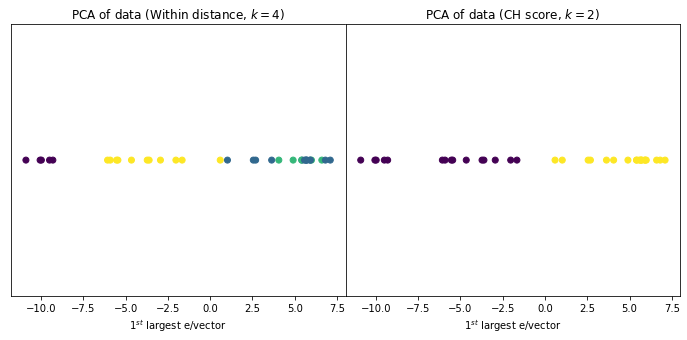

In [33]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.scatter(X_pca[:,0], np.zeros(len(X_pca[:,0])), c=optimal_labels_W, linewidths=1)
plt.xlabel('$1^{st}$ largest e/vector')
plt.title('PCA of data (Within distance, $k=4$)')
plt.yticks([])


fig.add_subplot(122)
plt.scatter(X_pca[:,0], np.zeros(len(X_pca[:,0])), c=optimal_labels_CH, linewidths=1)
plt.xlabel('$1^{st}$ largest e/vector')
plt.title('PCA of data (CH score, $k=2$)')
plt.yticks([])
plt.subplots_adjust(wspace = 0.)
plt.show()

+ k=4:  we can see that generally the clusters split the data along the first principal component well, however, visually there does seem to be a poor splitting between the green and blue clusters. Intuitively merging these two clusters would produce a better split along the first principal component.

+ k=2: the split seems very good, with there being a clear gap between both clusters.

Perhaps the intuitive split here would be into 3 clusters since there seems to be 3 clusters along the first principal component.


#### 2-D PCA

I now plot the reduction of the feature matrix into 2 dimensions, whereby, again, the different colours of the points refer to the different clusters the individuals belong.

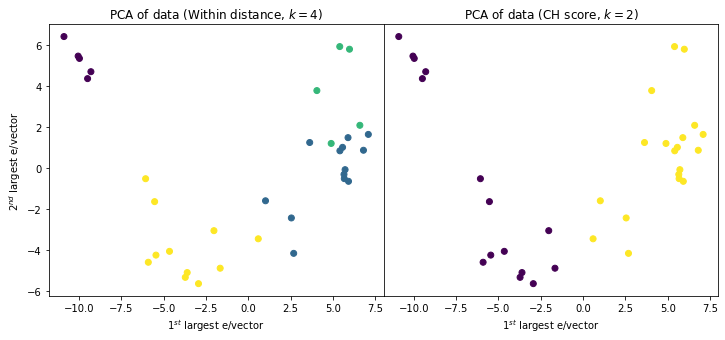

In [34]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.scatter(X_pca[:,0], X_pca[:,1], c=optimal_labels_W, linewidths=1)
plt.title('PCA of data (Within distance, $k=4$)')
plt.xlabel('$1^{st}$ largest e/vector')
plt.ylabel('$2^{nd}$ largest e/vector')

fig.add_subplot(122)
plt.scatter(X_pca[:,0], X_pca[:,1], c=optimal_labels_CH, linewidths=1)
plt.title('PCA of data (CH score, $k=2$)')
plt.xlabel('$1^{st}$ largest e/vector')
plt.yticks([])

plt.subplots_adjust(wspace = 0.)
plt.show()

+ k=4: the clusters well, with there being a clear seperation of the data unlike in the 1D case, that being said there does appear to be some minor mixing of the green and blue data points.

+ k=2: There is a clear split in these data points into the two clusters.


#### 3-D PCA

I now plot the reduction of the feature matrix into 3 dimensions, whereby, again, the different colours of the points refer to the different clusters the individuals belong.

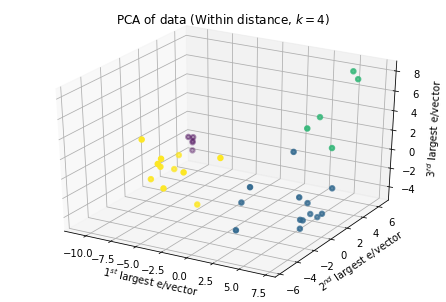

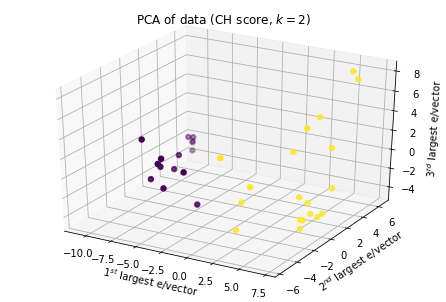

In [35]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=optimal_labels_W , linewidths=2)
ax.set_title('PCA of data (Within distance, $k=4$)')
ax.set_xlabel('$1^{st}$ largest e/vector') 
ax.set_ylabel('$2^{nd}$ largest e/vector') 
ax.set_zlabel('$3^{rd}$ largest e/vector') 
plt.show()


fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=optimal_labels_CH , linewidths=2)
ax.set_title('PCA of data (CH score, $k=2$)')
ax.set_xlabel('$1^{st}$ largest e/vector') 
ax.set_ylabel('$2^{nd}$ largest e/vector') 
ax.set_zlabel('$3^{rd}$ largest e/vector') 
plt.show()

We can again see that in both cases a a clear split of the data is seen when representing it in 3-dimensions. Though perhaps one could argue that on the $k=4$ case there is no clear reason to split the data into 4 clusters, when considering the representation of the data in 3 principal components.

### Task 2.2.2

Below I plot the proportion of the explained variance of the feature matrix. 

This is done by considering the eigenvalues of $\tilde{F}^T\tilde{F}$, where $\tilde{F}$ denotes the normalised feature matrix. 

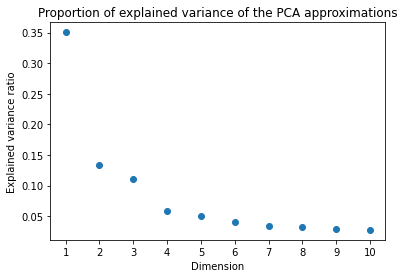

In [36]:
eig_total = sum(np.linalg.eigvalsh(C))

explained_variances = eigenvalues / eig_total
x = np.arange(1, len(eigenvalues)+1)
plt.scatter(x, explained_variances)
plt.xticks(x)
plt.xlabel('Dimension')
plt.ylabel('Explained variance ratio')
plt.title('Proportion of explained variance of the PCA approximations')
plt.show()

We can see that the $1^{\text{st}}$ largest eigenvalue is significantly larger than the others suggesting that the data can be well represented in one principal component.

After the first eigenvalue, eigenvalues 2 and 3 are the next highest before a significant drop, suggesting that a representation of the data in 2 or 3 dimensions would also be acceptable.

Beyond the third eigenvalue all eigenvalues are very small, suggesting that representing the data in further dimensions would not be efficient.

## Task 2.3 Graph-based analysis

### Task 2.3.1 Centralities

Below I have created functions that impliment:
+ Page Rank
+ Degree centrality
+ Eigenvector Centrality

when given an adjacency matrix.

#### Pagerank
Pagerank, which is defined in lecture notes as below.
$$
c_{PR_{t+1}} = \alpha (AD^{−1})c_{PR_{t}} + (1 − \alpha) \frac{1}{N}
$$
Where $A$ is the adjacency matrix, $D$ is the degree matrix and $\alpha \in [0,1]$ is the teleportation parameter (usually set to 0.85).


Which is obtained by solving for $c_{PR}$ in:
\begin{align*}
c_{PR} &= \alpha (AD^{−1})c_{PR} + (1 − \alpha) \frac{1}{N} \\
\implies \left( I - \alpha (AD^{−1}) \right) c_{PR} &= (1 − \alpha) \frac{1}{N}
\end{align*}
This is implimented below:

In [37]:
def pagerank(A, alpha=0.85):
    # alpha=0.85 by default as this is usually optimum (lecture notes)
    N = len(A)
    degrees = np.sum(A, axis=0)
    alphaM = -alpha * A/degrees
    a = (1 - alpha) / N
    np.fill_diagonal(alphaM, 1+np.diag(alphaM))
    
    return np.linalg.solve(alphaM, np.full(N, a))

#### Degree Centrality 

Degree centrality is simply the number of edges a node has, normalised by the number of edges of the graph. It is defined in lecture notes as below:
$$
c_d = \frac{\bf{d}}{2E} = \frac{A \bf{1}}{2E}
$$

Where E is the number of edges the graph has.

This is implimented below:



In [38]:
def degree_centrality(A):
    degrees = np.sum(A, axis=0) # equivalent to A@ones
    return  degrees / sum(degrees)

#### Eigenvector Centrality

Eigenvector centrality is a centrality method based off the concept high scoring nodes are connected to other high-scoring nodes. This is defined as in the notes as solving the eigenvector problem:
$$
Ac_e = \lambda c_e
$$
For the leading eigenvector, and is implemented below: 

In [39]:
def eigenvector_centrality(A):
    # since A is undirected => symmetric, hence we can use 'eigh' for efficiency 
    eigvals, eigvecs = np.linalg.eigh(A) 
    ans = eigvecs[:, np.argmax(eigvals)]
    return ans

I now calculate these respective centralities on the Karate club graph and perform a correlation plot as seen below:

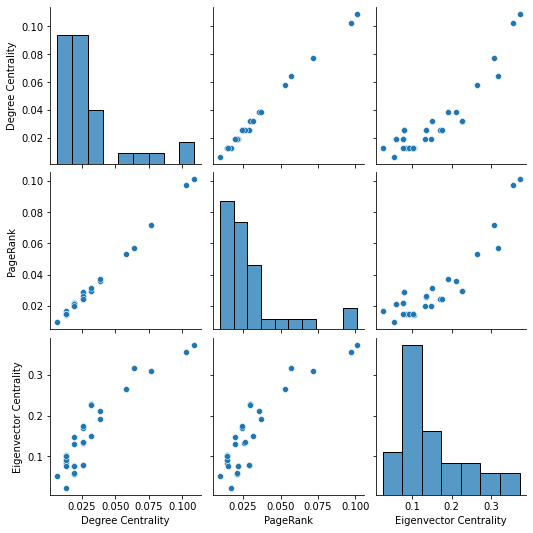

In [40]:
# Import Graph
A = np.genfromtxt('/content/drive/MyDrive/CW_FILES/karate_club_graph.csv', delimiter=',')
A = A[1:,1:] # Remove Headers and Indexes

# Calculate the centrality measures
nodes = np.arange(len(A))
p_r = pagerank(A)
d_c = degree_centrality(A)
e_c = eigenvector_centrality(A)


# Correlation plot
centralities = np.column_stack((nodes, d_c, p_r, e_c))
df = pd.DataFrame(centralities[:, 1:], columns=['Degree Centrality','PageRank', 'Eigenvector Centrality'])
sn.pairplot(df)
plt.show()

As we see there seems to be a very strong positive correlation between all these centralities. This can further be seen in the below correlation matrix:

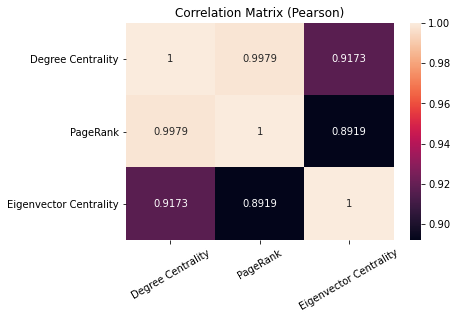

In [41]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True, fmt='.4g')
plt.xticks(rotation=30)
plt.title('Correlation Matrix (Pearson)')
plt.show()

Where we see that there is a particularly high correlation between pagerank and degree centrality, this is likely because they are very similar centrality methods, both considering the degree of each node.

Differences in pagerank and degree centrality would occur because, while degree centrality measures only the number of edges a corresponding node has, page rank also takes into account whether the node is connected to 'important' nodes.

For example:
Consider nodes 16 and 9. Both have the same degree (and so degree centrality), though node 16 has a larger pagerank, this is because it is connected to more important nodes than node 9. (this can be clearly seen when we plot the graph later) These centralities are shown below:




In [42]:
index = [16, 9]
headers=["Node", "Degree Centrality", "Page Rank"]
table = np.column_stack((index, d_c[index], p_r[index]))
print(tabulate(table, headers))

  Node    Degree Centrality    Page Rank
------  -------------------  -----------
    16            0.0128205    0.016784
     9            0.0128205    0.0143094


Considering eigenvector centrality, we see this is also highly correlated to both degree centrality and pagerank, this is because ultimately it is a centrality measure, despite it being based off spectral methods. And also, like pagerank, eigenvector centrality considers the nodes connected to the a given node, and their importance to calculate its respective centrality.

For completeness all nodes and their corresponding centralities are shown below: 

In [43]:
headers=['Node', 'Degree Centrality', 'Page Rank', 'Eigenvector Centrality']
table = centralities
print(tabulate(table, headers))

  Node    Degree Centrality    Page Rank    Eigenvector Centrality
------  -------------------  -----------  ------------------------
     0           0.102564     0.0969973                  0.355491
     1           0.0576923    0.0528769                  0.26596
     2           0.0641026    0.0570785                  0.317193
     3           0.0384615    0.0358599                  0.21118
     4           0.0192308    0.021978                   0.0759688
     5           0.025641     0.0291112                  0.079483
     6           0.025641     0.0291112                  0.079483
     7           0.025641     0.0244905                  0.17096
     8           0.0320513    0.0297661                  0.227404
     9           0.0128205    0.0143094                  0.102674
    10           0.0192308    0.021978                   0.0759688
    11           0.00641026   0.00956475                 0.0528557
    12           0.0128205    0.0146449                  0.0842546
    13 

Let us consider the top 8 nodes by degree centrality, pagerank and eigenvector centrality:

In [44]:
headers=['Top DC Nodes', 'Top PR Nodes', 'Top EC Nodes']
table = np.column_stack((np.argsort(-d_c)[:8], np.argsort(-p_r)[:8], np.argsort(-e_c)[:8]))
print(tabulate(table, headers))

  Top DC Nodes    Top PR Nodes    Top EC Nodes
--------------  --------------  --------------
            33              33              33
             0               0               0
            32              32               2
             2               2              32
             1               1               1
             3              31               8
            31               3              13
            13              23               3


As we would expect these rankings are very similar.

Below I consider Spearman's rank correlation coefficient (https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) on the aforementioned centralities. Since this specifically considers the ranks of the measures as opposed to their value, Spearman's rank correlation is defined as below:

$$
r_{s} = {\frac {\operatorname {cov} (\operatorname {rg} _{X},\operatorname {rg} _{Y})}{\sigma _{\operatorname {rg} _{X}}\sigma _{\operatorname {rg} _{Y}}}}
$$
Where $\operatorname {rg} _{X}$ denotes the ranking of data $X$.

This can be thought of as the correlation of the ranks, and is displayed below:

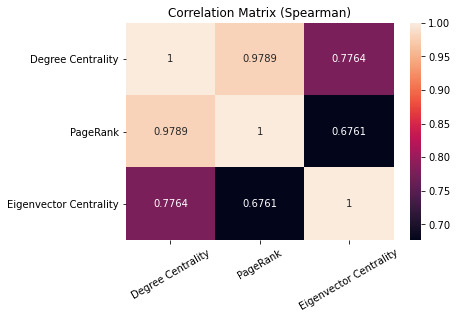

In [45]:
corrMatrix = df.corr(method='spearman')
sn.heatmap(corrMatrix, annot=True, fmt='.4g')
plt.xticks(rotation=30)
plt.title('Correlation Matrix (Spearman)')
plt.show()

This confirms what we hypothesised previously by looking at the correlation of the scores. Although the rankings generally show slightly smaller correlation.


### Task 2.3.2 ​Community detection

Below I use the Clauset-Newman-Moore greedy modularity maximisation algorithm from NetworkX, to find the optimal clusterings from the Karate Club graph.

In [46]:
# Find the communities
graph = nx.from_numpy_array(A)
communities = nxcom.greedy_modularity_communities(graph)
num_communities = len(communities)
print('There are k* = %d different clusters' % num_communities)

labels = np.empty(len(A))        
for i in range(num_communities):
    labels[list(communities[i])] = i
 
table = []
for i in range(3):
    table += [[i, tuple(communities[i])]]
headers=["Community", "Nodes"]
print(tabulate(table, headers))


There are k* = 3 different clusters
  Community  Nodes
-----------  -------------------------------------------------------------------
          0  (32, 33, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31)
          1  (1, 2, 3, 7, 9, 12, 13, 17, 21)
          2  (0, 4, 5, 6, 10, 11, 16, 19)


The algorithm returns an optimal $k$ of $k^* = 3$. With the nodes in the clusters as shown above. 

For a more visual representation I display this on the Karate Club graph, where the colours of the nodes refer to the cluster they're assigned.

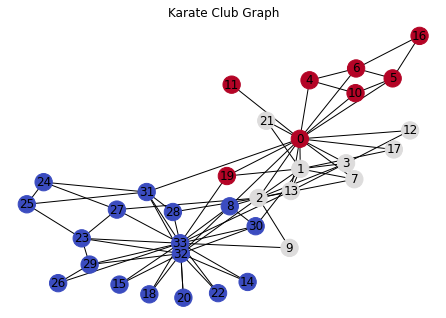

In [47]:
pos = nx.spring_layout(graph, seed=112511190)
edges = graph.edges()
nx.draw(graph, pos, with_labels=True, cmap=plt.cm.coolwarm, node_color=labels)
plt.title('Karate Club Graph')
plt.show()

As required the top 8 nodes by degree centrality are shown below:

In [48]:
index = np.argsort(-d_c)[:8]
headers=["Node", "Community", "Degree Centrality", "Page Rank"]
table = np.column_stack((index, labels[index], d_c[index], p_r[index]))
print(tabulate(table, headers))

  Node    Community    Degree Centrality    Page Rank
------  -----------  -------------------  -----------
    33            0            0.108974     0.100919
     0            2            0.102564     0.0969973
    32            0            0.0769231    0.0716932
     2            1            0.0641026    0.0570785
     1            1            0.0576923    0.0528769
     3            1            0.0384615    0.0358599
    31            0            0.0384615    0.0371581
    13            1            0.0320513    0.0295365


Also the top 8 nodes by page rank:

In [49]:
index = np.argsort(-p_r)[:8]
table = np.column_stack((index, labels[index], d_c[index], p_r[index]))
print(tabulate(table, headers))

  Node    Community    Degree Centrality    Page Rank
------  -----------  -------------------  -----------
    33            0            0.108974     0.100919
     0            2            0.102564     0.0969973
    32            0            0.0769231    0.0716932
     2            1            0.0641026    0.0570785
     1            1            0.0576923    0.0528769
    31            0            0.0384615    0.0371581
     3            1            0.0384615    0.0358599
    23            0            0.0320513    0.0315225


We can see that, as we would expect from looking at the correlation between degree centrality and page rank we have almost identical rankings of the top 8.

The only difference being node 23 and node 13 being in 8th position. Looking at the degree centrality of these nodes however, we can notice that they have the same degree centrality and hence both are in joint 8th position, thus the top 8 are arguably identical aside from this choice of node to be in position 8 for degree centrality.


It can also be noted that community 1 contains the most (or joint most depending on which ranking is used) nodes in the top 8, followed by community 0 and then by community 2. This can be seen clearly in the graph above, since in community 2  (aside from node 0) all nodes are not very well connected, in comparison to communities 0 and 1 that are much more connected. 

### Task 2.3.3 Comparing clusterings

The Adjusted Rand Index is used to measure the similarity between the clusters.

The adjusted rand index, is defined in lecture notes, as below:


Contingency table:
$$
{\begin{array}{c|cccc|c}{{} \atop X}\!\diagdown \!^{Y}&Y_{1}&Y_{2}&\cdots &Y_{s}&{\text{sums}}\\\hline X_{1}&n_{11}&n_{12}&\cdots &n_{1s}&a_{1}\\X_{2}&n_{21}&n_{22}&\cdots &n_{2s}&a_{2}\\\vdots &\vdots &\vdots &\ddots &\vdots &\vdots \\X_{r}&n_{r1}&n_{r2}&\cdots &n_{rs}&a_{r}\\\hline {\text{sums}}&b_{1}&b_{2}&\cdots &b_{s}&\end{array}}
$$

Where $X$ and $Y$ are the two clusterings to be compared, and $n_{ij} := \left| X_i \cap Y_j \right|$.


$$
 ARI={\frac {\left.\sum _{ij}{\binom {n_{ij}}{2}}-\left[\sum _{i}{\binom {a_{i}}{2}}\sum _{j}{\binom {b_{j}}{2}}\right]\right/{\binom {n}{2}}}{\left.{\frac {1}{2}}\left[\sum _{i}{\binom {a_{i}}{2}}+\sum _{j}{\binom {b_{j}}{2}}\right]-\left[\sum _{i}{\binom {a_{i}}{2}}\sum _{j}{\binom {b_{j}}{2}}\right]\right/{\binom {n}{2}}}}
$$

This is implimented in `ARI()`

The rand index is a measure of similarity between two clusters, the adjusted rand index, is almost identical though has been adjusted to take into account chance groupings of elements.

The adjusted rand index takes values between -1 and 1, with a value of 1 showing the highest similarity between clusterings.

In [50]:
def ARI(labels1, labels2):
    n = len(labels1)
    comm1 = len(np.unique(labels1))
    comm2 = len(np.unique(labels2))
    
    nij =  np.empty((comm1, comm2))
    
    for i in range(comm1):
        cond = labels1==i
        for j in range(comm2):
            nij[i, j] = sum(cond[labels2==j])
            
    a = np.sum(nij, axis = 1)
    b = np.sum(nij, axis = 0)
    # NB. nC2 represents the n choose 2 function, defined prior.
    sum_aC2 = sum(nC2(a))
    sum_bC2 = sum(nC2(b))
    nC2_ = nC2(n)
    product_term = sum_aC2*sum_bC2 / nC2_
    sum_term = sum_aC2 + sum_bC2 
    
    ans = (np.sum(nC2(nij)) - product_term) / (0.5*sum_term - product_term)
    return ans

Below I apply the ARI to the optimal clusterings found in Task 2.1.2 (that is found by considering the CH score and $k=2$). And compare this to the clustering just found in Task 2.3.2 as well as the ground truth.

In [51]:
actu_labels = np.genfromtxt('/content/drive/MyDrive/CW_FILES/ground_truth_karate_club.csv', delimiter=',', dtype = np.str)[1:, 1:]
actu_labels = np.array([0 if label=='Mr. Hi' else 1 for label in actu_labels])



print('ARI of Task 2.1.2 clustering vs Task 2.3.2 clustering', ARI(optimal_labels_CH, labels))
print('ARI of Task 2.1.2 clustering vs ground truth', ARI(optimal_labels_CH, actu_labels))  
print('ARI of Task 2.3.2 clustering vs ground truth', ARI(labels, actu_labels))

ARI of Task 2.1.2 clustering vs Task 2.3.2 clustering -0.031487014479429976
ARI of Task 2.1.2 clustering vs ground truth 0.0012970168612192327
ARI of Task 2.3.2 clustering vs ground truth 0.5684394071490846


#### ARI of Task 2.1.2 clustering vs Task 2.3.2 clustering

We can see that this has a very low ARI (it is slightly negative suggesting that their similarity is less than random clusterings), hence the clustering found in Task 2.1.2 is very dissimilar to that found in Task 2.3.2.

#### ARI of Task 2.1.2 clustering vs ground truth

We can see that this again has a very low ARI, suggesting that the clustering found in Task 2.1.2 is very dissimilar to the ground truth split of the Karate Club.

#### ARI of Task 2.3.2 clustering vs ground truth

We can see that the ARI is fairly high, suggesting that this is fairly similar to that of the ground truth, much more so than the clusterings found in Task 2.1.2. Despite this the index is still far from one suggesting that it is not a great match to the ground truth.